# HappyWhale Setup

Thomas LI et Hugo BOUIGEON

**This notebook prepares the dataset, the dataloader while augmenting it and implements a first stupid CNN to determine either the species or the ID**

# Install

In [ ]:
!pip install -U albumentations
!pip install torch-summary

You should consider upgrading via the '/anaconda/envs/py38_default/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/anaconda/envs/py38_default/bin/python -m pip install --upgrade pip' command.


# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch
import pickle
import cv2

from tqdm.notebook import tqdm, tnrange
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models as models


import albumentations as alb
from albumentations.pytorch import ToTensorV2

# Choose Dataset of Cropped Dataset (change file path if necessary)

In [ ]:
# root = ''
# train_dir = 'train_images'
# test_dir = 'test_images'

#---CROPPED DATASET--- 100 fois plus rapide
root = ''
train_dir = 'crop/train_images'
test_dir = 'crop/test_images'

In [ ]:
df = pd.read_csv("train.csv")
df.head()

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392


In [ ]:
##Ajout d'une colonne "file_path" donnant le chemin vers l'image correspondant au label

def train_path(id):
    return f"{train_dir}/{id}"

df['file_path'] = df['image'].apply(train_path)
df.head()

,image,species,individual_id,file_path
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9,crop/train_images/00021adfb725ed.jpg
1,000562241d384d.jpg,humpback_whale,1a71fbb72250,crop/train_images/000562241d384d.jpg
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b,crop/train_images/0007c33415ce37.jpg
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063,crop/train_images/0007d9bca26a99.jpg
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392,crop/train_images/00087baf5cef7a.jpg


**Validation Dataset**

In [ ]:
df_val = pd.read_csv('sample_submission.csv')
df_val.head()

,image,predictions
0,000110707af0ba.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
1,0006287ec424cb.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
2,000809ecb2ccad.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
3,00098d1376dab2.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
4,000b8d89c738bd.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...


In [ ]:
##Ajout d'une colonne "file_path" donnant le chemin vers l'image correspondant au label

def val_path(img_id):
    return f"{test_dir}/{img_id}"

df_val['file_path'] = df_val['image'].apply(val_path)
df_val['label'] = 0
df_val.head()

,image,predictions,file_path,label
0,000110707af0ba.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...,crop/test_images/000110707af0ba.jpg,0
1,0006287ec424cb.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...,crop/test_images/0006287ec424cb.jpg,0
2,000809ecb2ccad.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...,crop/test_images/000809ecb2ccad.jpg,0
3,00098d1376dab2.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...,crop/test_images/00098d1376dab2.jpg,0
4,000b8d89c738bd.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...,crop/test_images/000b8d89c738bd.jpg,0


## Constants

In [ ]:
N_individus = len(df['individual_id'].unique())
N_species = len(df['species'].unique())
N_entries = len(df)
N_entries_val = len(df_val)
print(f'N_individus = {N_individus}\nN_species = {N_species}\nN_entries = {N_entries}\nN_entries_val = {N_entries_val}')

N_individus = 15587
N_species = 30
N_entries = 51033
N_entries_val = 27956


In [ ]:
#Création de dict_id_inv qui à un string_id attribue un int unique
individual_identities = df['individual_id'].unique()
dict_id = dict(enumerate(individual_identities))
dict_id[N_individus-1]
dict_id_inv = {v: k for k, v in dict_id.items()}

#Création de dict_species_inv qui à un string_specie attribue un int unique
N_species = len(df['species'].unique())
species_array = df['species'].unique()
dict_species = dict(enumerate(species_array))
dict_species_inv = {v: k for k, v in dict_species.items()}


def string_id_to_int_id(string_id):
    """
    Attribue un int unique pour chaque string_id
    """
    return dict_id_inv[string_id]

def int_id_to_string_id(int_id):
    """
    Renvoie le string_id correspondant au int_id
    """
    return dict_id[int_id]

def string_species_to_int_species(string_species):
    """
    Attribue un int unique pour chaque string_species
    """
    return dict_species_inv[string_species]

# Choose Label = Individual or Label = Species

In [ ]:
#df['label'] = df['individual_id'].apply(string_id_to_int_id)

df['label'] = df['species'].apply(string_species_to_int_species)

In [ ]:
df.head()

,image,species,individual_id,file_path,label
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9,crop/train_images/00021adfb725ed.jpg,0
1,000562241d384d.jpg,humpback_whale,1a71fbb72250,crop/train_images/000562241d384d.jpg,1
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b,crop/train_images/0007c33415ce37.jpg,2
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063,crop/train_images/0007d9bca26a99.jpg,3
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392,crop/train_images/00087baf5cef7a.jpg,1


In [ ]:
#Création de la classe Dataset
class DatasetBaleine(Dataset):
    def __init__(self, df, transform =None):
        self.df = df
        self.name = df['file_path'].values
        self.label = df['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.name[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.label[idx]

        if self.transform:
            image = self.transform(image=image)["image"]

        return {
            'image': image,
            'label': label
        }

# Configuration

In [ ]:
CFG  = {'img_size' : 256,
        'batch_size': 16 ,
        'augmentations' : 1,
        'test_size' : 0.2,
        'mini_train_size' : 1000,
        'mini_test_size' : 200,
        'num_workers' : 6,
       }

# Augmentations

In [ ]:
def BaleineTransform(train):
    if(train == True):
        BaleineTransf = alb.Compose([
                        alb.Resize(CFG['img_size'], CFG['img_size']),
                        alb.ShiftScaleRotate(rotate_limit=30),
                        alb.HueSaturationValue(),
                        alb.RandomBrightnessContrast(),
                        alb.Normalize(),
                        ToTensorV2()],p=1.0)
    else:
        BaleineTransf = alb.Compose([
                        alb.Normalize(),
                        alb.Resize(CFG['img_size'], CFG['img_size']),
                        ToTensorV2()],p=1.0)

    return BaleineTransf

In [ ]:
df.head()

,image,species,individual_id,file_path,label
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9,crop/train_images/00021adfb725ed.jpg,0
1,000562241d384d.jpg,humpback_whale,1a71fbb72250,crop/train_images/000562241d384d.jpg,1
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b,crop/train_images/0007c33415ce37.jpg,2
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063,crop/train_images/0007d9bca26a99.jpg,3
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392,crop/train_images/00087baf5cef7a.jpg,1


In [ ]:
len(df)

51033

In [ ]:
df, df_test, _, _ = train_test_split(df, df['label'], test_size=CFG['test_size'], random_state=123, stratify=df['species'])

In [ ]:
N_entries_train = len(df)
N_entries_test = len(df_test)
print(f'N_entries_train = {N_entries_train}\nN_entries_test = {N_entries_test}')

N_entries_train = 40826
N_entries_test = 10207


In [ ]:
df_val.head()

,image,predictions,file_path,label
0,000110707af0ba.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...,crop/test_images/000110707af0ba.jpg,0
1,0006287ec424cb.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...,crop/test_images/0006287ec424cb.jpg,0
2,000809ecb2ccad.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...,crop/test_images/000809ecb2ccad.jpg,0
3,00098d1376dab2.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...,crop/test_images/00098d1376dab2.jpg,0
4,000b8d89c738bd.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...,crop/test_images/000b8d89c738bd.jpg,0


In [ ]:
BaleineDataset = DatasetBaleine(df, transform = BaleineTransform(train = False))
BaleineDataset_test = DatasetBaleine(df_test, transform = BaleineTransform(train = False))
BaleineDataset_val = DatasetBaleine(df_val, transform = BaleineTransform(train = False))

# On augmente le dataset
for i in range(CFG['augmentations']-1):
    BaleineDataset = torch.utils.data.ConcatDataset([DatasetBaleine(df, transform = BaleineTransform(train = True)),BaleineDataset])

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

#creating indexes
idx = np.arange(N_entries_train*CFG['augmentations'])
np.random.shuffle(idx)

mini_idx_train = idx[:CFG['mini_train_size']]
mini_idx_test = idx[CFG['mini_train_size']:CFG['mini_train_size']+CFG['mini_test_size']]

#creating the dataloaders
num_workers = CFG['num_workers']
trainloader = torch.utils.data.DataLoader(BaleineDataset, batch_size= CFG['batch_size'], shuffle=False, sampler=SubsetRandomSampler(idx), num_workers=num_workers)
testloader = torch.utils.data.DataLoader(BaleineDataset_test, batch_size= CFG['batch_size'], shuffle=True, num_workers=num_workers)
mini_trainloader = torch.utils.data.DataLoader(BaleineDataset, batch_size= CFG['batch_size'], shuffle=False, sampler=SubsetRandomSampler(mini_idx_train), num_workers=num_workers)
mini_testloader = torch.utils.data.DataLoader(BaleineDataset, batch_size= CFG['batch_size'], shuffle=False, sampler=SubsetRandomSampler(mini_idx_test), num_workers=num_workers)

valloader = torch.utils.data.DataLoader(BaleineDataset_val, batch_size= 1, shuffle=False, num_workers=num_workers)

In [ ]:
len(testloader)

638

In [ ]:
len(trainloader)

2552

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

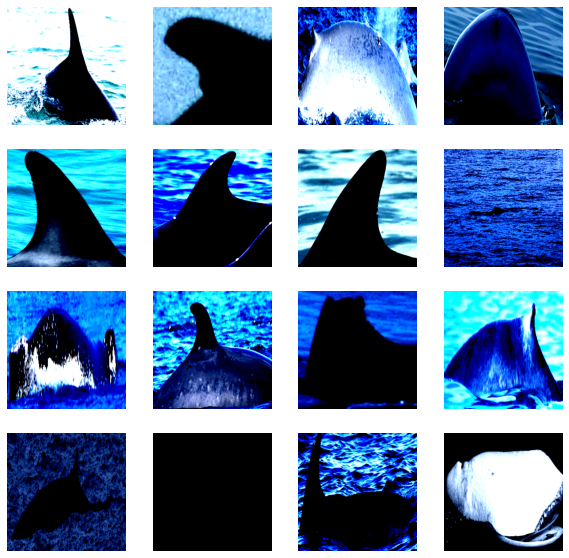

In [ ]:
plt.figure(figsize=(10,10))
tmp = next(iter(trainloader))
for i in range(16):
    plt.subplot(4,4,i +1)
    plt.imshow(torch.movedim(tmp['image'][i],0,2))
    plt.axis('off')
plt.show()

In [ ]:
tmp['image'][0].shape

torch.Size([3, 256, 256])

In [ ]:
tmp['label']

tensor([   90,  6373,  9246,   828,   787,  6512,  4519,  3975,   208,  1093,
        13220, 11320,  7007, 12031,  6366,  4315])

# Training functions

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
def accuracy(net, dataloader, cuda=True):
    """
    Renvoie le poucentage de précision (TOP1 et pas TOP5) et le taux de loss
    """
    net.eval()
    correct = 0
    loss = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(dataloader, desc='Processing accuracy', leave=False):
            images, labels = data['image'], data['label']

            if cuda:
                images = images.type(torch.cuda.FloatTensor)
                labels = labels.type(torch.cuda.LongTensor)

            outputs = net(images)
            loss+= criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    net.train()
    return (100.0 * correct / total, loss/total)

In [ ]:
def top5accuracy(net, dataloader, cuda=True):
    """
    Renvoie le poucentage de précision TOP5 et le taux de loss
    """
    net.eval()
    correct = 0
    loss = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(dataloader, desc='Processing accuracy', leave=False):
            images, labels = data['image'], data['label']

            if cuda:
                images = images.type(torch.cuda.FloatTensor)
                labels = labels.type(torch.cuda.LongTensor)

            outputs = net(images)
            loss+= criterion(outputs, labels).item()
            _, predicted = torch.topk(outputs.data, k=5)
            total += labels.size(0)
            for i in range(len(labels)):
                correct += (int)(labels[i] in predicted[i])
    net.train()
    return (100.0 * correct / total, loss/total)

In [ ]:
def train(net, optimizer, train_loader, test_loader, loss,  n_epoch = 5, PATH = 'lastmodel',
          train_acc_period = 100,
          test_acc_period = 5,
          cuda=False):
    """
    Entraine le modele en plottant les courbes de précision et de loss et en affichant le taux de précision final.
    """
    loss_train = []
    loss_test = []
    accuracy_train = []
    accuracy_test = []

    total = 0
    for epoch in tqdm(range(n_epoch), desc='Epoch'):  # loop over the dataset multiple times
        for data in tqdm(train_loader, desc='Processing epoch', leave=False):
            inputs, labels = data['image'], data['label']

            if cuda:
                inputs = inputs.type(torch.cuda.FloatTensor)
                labels = labels.type(torch.cuda.LongTensor)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total += labels.size(0)

        with torch.no_grad():
            precision_train, cout_train = accuracy(net, train_loader, cuda=cuda)
            precision_test, cout_test = accuracy(net, test_loader, cuda=cuda)
            loss_train.append(cout_train)
            loss_test.append(cout_test)
            accuracy_train.append(precision_train)
            accuracy_test.append(precision_test)
            print(f'Epoch {epoch}: precision_train = {precision_train}, cout_train = {cout_train}, precision_test = {precision_test}, cout_test ={cout_test}')
            torch.save(net, PATH)
            print(f'Saved model under {PATH}')

    x = [i for i in range(0, n_epoch)]
    plt.figure(figsize = (8,6))
    plt.subplot(2, 1, 1) #lignes, colonnes, position (sens de la lecture)
    plt.plot(x, accuracy_train, label="precision_train", c='blue', ls='--', lw=1)
    plt.plot(x, accuracy_test, label="precision_test", c='red', ls='--', lw=1)
    plt.title('Précision')
    plt.xlabel('epochs')
    plt.ylabel('Précision')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(x, loss_train, label="loss_train", c='blue', ls='--', lw=1)
    plt.plot(x, loss_test, label="loss_test", c='red', ls='--', lw=1)
    plt.title('Loss')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    print('Finished Training')
    print(f'---Accuracy--- = {accuracy_test[-1]}')
    print(f'loss_train = {loss_train}')
    print(f'loss_test = {loss_test}')
    print(f'accuracy_train = {accuracy_train}')
    print(f'accuracy_test = {accuracy_test}')


In [ ]:
def top5train(net, optimizer, train_loader, test_loader, loss, n_epoch = 5, PATH = 'lastmodel',
          train_acc_period = 100,
          test_acc_period = 5,
          cuda=False):
    """
    Entraine le modele en plottant les courbes de précision et de loss et en affichant le taux de précision final.
    """
    loss_train = []
    loss_test = []
    accuracy_train = []
    accuracy_test = []

    total = 0
    for epoch in tqdm(range(n_epoch), desc='Epoch'):  # loop over the dataset multiple times
        for data in tqdm(train_loader, desc='Processing epoch', leave=False):
            inputs, labels = data['image'], data['label']

            if cuda:
                inputs = inputs.type(torch.cuda.FloatTensor)
                labels = labels.type(torch.cuda.LongTensor)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total += labels.size(0)

        with torch.no_grad():
            precision_train, cout_train = top5accuracy(net, train_loader, cuda=cuda)
            precision_test, cout_test = top5accuracy(net, test_loader, cuda=cuda)
            loss_train.append(cout_train)
            loss_test.append(cout_test)
            accuracy_train.append(precision_train)
            accuracy_test.append(precision_test)
            print(f'Epoch {epoch}: precision_train = {precision_train}, cout_train = {cout_train}, precision_test = {precision_test}, cout_test ={cout_test}')
            torch.save(net, PATH)
            print(f'Saved model under {PATH}')

    x = [i for i in range(0, n_epoch)]
    plt.figure(figsize = (8,6))
    plt.subplot(2, 1, 1) #lignes, colonnes, position (sens de la lecture)
    plt.plot(x, accuracy_train, label="precision_train", c='blue', ls='--', lw=1)
    plt.plot(x, accuracy_test, label="precision_test", c='red', ls='--', lw=1)
    plt.title('Précision')
    plt.xlabel('epochs')
    plt.ylabel('Précision')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(x, loss_train, label="loss_train", c='blue', ls='--', lw=1)
    plt.plot(x, loss_test, label="loss_test", c='red', ls='--', lw=1)
    plt.title('Loss')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    print('Finished Training')
    print(f'---Accuracy--- = {accuracy_test[-1]}')
    print(f'loss_train = {loss_train}')
    print(f'loss_test = {loss_test}')
    print(f'accuracy_train = {accuracy_train}')
    print(f'accuracy_test = {accuracy_test}')

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
#         nn.init.xavier_uniform_(m.weight)
        nn.init.xavier_normal_(m.weight)

In [ ]:
class Network1(nn.Module):
    def __init__(self):
        super(Network1, self).__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)) #32
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)) #16
        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)) #8
        self.classifier = torch.nn.Sequential(
#             nn.Linear(32*32*6,N_individus),
            nn.Linear(8*8*64,500),
            nn.ReLU(),
            nn.Linear(500,N_species),      #Pour les species
            nn.LogSoftmax(dim=1))

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)

        return out

In [ ]:
from torchsummary import summary
net = Network1()
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
summary(net,(3, 256, 256))

using cuda
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 128, 128]        --
|    └─Conv2d: 2-1                       [-1, 16, 256, 256]        1,216
|    └─ReLU: 2-2                         [-1, 16, 256, 256]        --
|    └─MaxPool2d: 2-3                    [-1, 16, 128, 128]        --
├─Sequential: 1-2                        [-1, 32, 64, 64]          --
|    └─Conv2d: 2-4                       [-1, 32, 128, 128]        12,832
|    └─ReLU: 2-5                         [-1, 32, 128, 128]        --
|    └─MaxPool2d: 2-6                    [-1, 32, 64, 64]          --
├─Sequential: 1-3                        [-1, 64, 32, 32]          --
|    └─Conv2d: 2-7                       [-1, 64, 64, 64]          51,264
|    └─ReLU: 2-8                         [-1, 64, 64, 64]          --
|    └─MaxPool2d: 2-9                    [-1, 64, 32, 32]          --
├─Sequential: 1-4                        [-1, 30]              

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 128, 128]        --
|    └─Conv2d: 2-1                       [-1, 16, 256, 256]        1,216
|    └─ReLU: 2-2                         [-1, 16, 256, 256]        --
|    └─MaxPool2d: 2-3                    [-1, 16, 128, 128]        --
├─Sequential: 1-2                        [-1, 32, 64, 64]          --
|    └─Conv2d: 2-4                       [-1, 32, 128, 128]        12,832
|    └─ReLU: 2-5                         [-1, 32, 128, 128]        --
|    └─MaxPool2d: 2-6                    [-1, 32, 64, 64]          --
├─Sequential: 1-3                        [-1, 64, 32, 32]          --
|    └─Conv2d: 2-7                       [-1, 64, 64, 64]          51,264
|    └─ReLU: 2-8                         [-1, 64, 64, 64]          --
|    └─MaxPool2d: 2-9                    [-1, 64, 32, 32]          --
├─Sequential: 1-4                        [-1, 30]                  --
|   

In [ ]:
class Network2(nn.Module):
    def __init__(self):
        super(Network2, self).__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)) #32
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)) #16
        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)) #8
        self.classifier = torch.nn.Sequential(
            nn.Linear(16*16*64,500),
            nn.ReLU(),
            nn.Linear(500,N_individus),      #Pour les species
            nn.LogSoftmax(dim=1))

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)

        return out

In [ ]:
net = Network2()
net.cuda()
top5accuracy(net, mini_testloader, cuda=True)

Processing accuracy:   0%|          | 0/13 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x65536 and 16384x500)

# Transfer learning with other models

In [ ]:
import torchvision.models as models

In [ ]:
resnet18 = models.resnet18(pretrained=True)

In [ ]:
resnet18.fc = nn.Sequential(
            #nn.Dropout(),
            nn.Linear(512, 128),
            nn.ReLU(),
            #nn.Dropout(),
            nn.Linear(128, 30),
            nn.LogSoftmax(dim=1)
)

In [ ]:
summary(net,(3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 64, 64]          9,408
├─BatchNorm2d: 1-2                       [-1, 64, 64, 64]          128
├─ReLU: 1-3                              [-1, 64, 64, 64]          --
├─MaxPool2d: 1-4                         [-1, 64, 32, 32]          --
├─Sequential: 1-5                        [-1, 64, 32, 32]          --
|    └─BasicBlock: 2-1                   [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 32, 32]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-3                    [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 32, 32]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-6                    [-1, 64, 32, 32]          --
|    └─BasicBlock: 2-2                   [-1, 64, 32, 32]          --
|

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 64, 64]          9,408
├─BatchNorm2d: 1-2                       [-1, 64, 64, 64]          128
├─ReLU: 1-3                              [-1, 64, 64, 64]          --
├─MaxPool2d: 1-4                         [-1, 64, 32, 32]          --
├─Sequential: 1-5                        [-1, 64, 32, 32]          --
|    └─BasicBlock: 2-1                   [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 32, 32]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-3                    [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 32, 32]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-6                    [-1, 64, 32, 32]          --
|    └─BasicBlock: 2-2                   [-1, 64, 32, 32]          --
|

using cuda


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/16 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/16 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/4 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/16 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/16 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/4 [00:00<?, ?it/s]

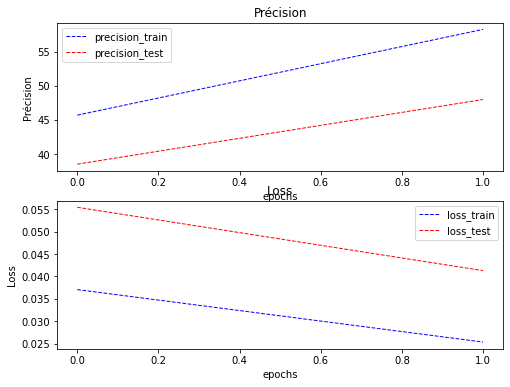

Finished Training
Accuracy = 48.0


In [ ]:
net = resnet18
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
train(net, optimizer, mini_trainloader, mini_testloader,criterion,  n_epoch = 2,
      train_acc_period = 10,
      test_acc_period = 1000, cuda = use_cuda)

In [ ]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Sequential(
            #nn.Dropout(),
            nn.Linear(512, 128),
            nn.ReLU(),
            #nn.Dropout(),
            ArcFace(128, 30),
)

NameError: name 'ArcFace' is not defined

# First Model

using cuda


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/32 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/32 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/32 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/32 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/157 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/32 [00:00<?, ?it/s]

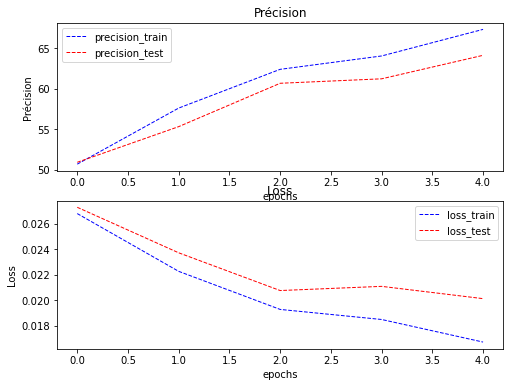

Finished Training
Accuracy = 64.1


In [ ]:
#Res = 64
net = Network1()
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
train(net, optimizer, mini_trainloader, mini_testloader,criterion,  n_epoch = 5,
      train_acc_period = 10,
      test_acc_period = 1000, cuda = use_cuda)

In [ ]:
#accuracy(net, mini_testloader, cuda=False)

using cuda


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/63 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/63 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 0: precision_train = 46.4, cout_train = 0.1291553409099579, precision_test = 35.0, cout_test =0.14812251091003417
Saved model under lastmodel


Processing epoch:   0%|          | 0/63 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/63 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1: precision_train = 54.8, cout_train = 0.10412982428073883, precision_test = 39.0, cout_test =0.13316332221031188
Saved model under lastmodel


Processing epoch:   0%|          | 0/63 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/63 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2: precision_train = 64.9, cout_train = 0.07906690949201584, precision_test = 45.0, cout_test =0.1309951961040497
Saved model under lastmodel


Processing epoch:   0%|          | 0/63 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/63 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3: precision_train = 78.5, cout_train = 0.0477691842019558, precision_test = 46.5, cout_test =0.1267841112613678
Saved model under lastmodel


Processing epoch:   0%|          | 0/63 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/63 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4: precision_train = 88.4, cout_train = 0.029488837391138077, precision_test = 46.0, cout_test =0.13802782952785492
Saved model under lastmodel


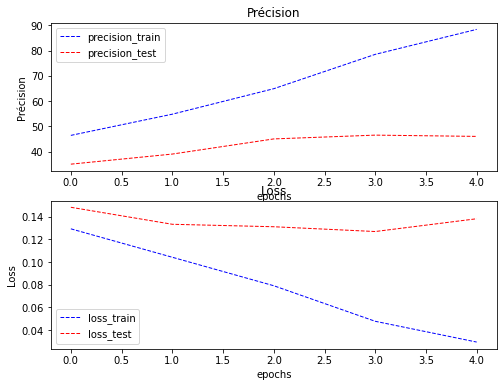

Finished Training
---Accuracy--- = 46.0
loss_train = [0.1291553409099579, 0.10412982428073883, 0.07906690949201584, 0.0477691842019558, 0.029488837391138077]
loss_test = [0.14812251091003417, 0.13316332221031188, 0.1309951961040497, 0.1267841112613678, 0.13802782952785492]
accuracy_train = [46.4, 54.8, 64.9, 78.5, 88.4]
accuracy_test = [35.0, 39.0, 45.0, 46.5, 46.0]


In [ ]:
net = Network1()
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
train(net, optimizer, trainloader, testloader,criterion,  n_epoch = 5,
      train_acc_period = 10,
      test_acc_period = 1000, cuda = use_cuda)

using cuda


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/2042 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2042 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch 0: precision_train = 62.504592774035515, cout_train = 0.08409475692834725, precision_test = 61.18050453098212, cout_test =0.08674024791072871
Saved model under lastmodel


Processing epoch:   0%|          | 0/2042 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2042 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch 1: precision_train = 70.60012247397428, cout_train = 0.061058332677075125, precision_test = 67.59735488611315, cout_test =0.06730916908915476
Saved model under lastmodel


Processing epoch:   0%|          | 0/2042 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2042 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch 2: precision_train = 75.20208205756276, cout_train = 0.05064272211598824, precision_test = 70.90374724467303, cout_test =0.06009434257729101
Saved model under lastmodel


Processing epoch:   0%|          | 0/2042 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2042 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch 3: precision_train = 79.6601347213717, cout_train = 0.041260050171706766, precision_test = 73.74479549350967, cout_test =0.054985907975289565
Saved model under lastmodel


Processing epoch:   0%|          | 0/2042 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2042 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch 4: precision_train = 82.04531537048378, cout_train = 0.035522378733825334, precision_test = 74.81018858682341, cout_test =0.05387328433553991
Saved model under lastmodel


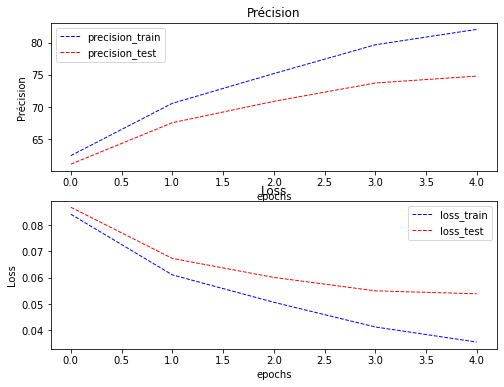

Finished Training
---Accuracy--- = 74.81018858682341
loss_train = [0.08409475692834725, 0.061058332677075125, 0.05064272211598824, 0.041260050171706766, 0.035522378733825334]
loss_test = [0.08674024791072871, 0.06730916908915476, 0.06009434257729101, 0.054985907975289565, 0.05387328433553991]
accuracy_train = [62.504592774035515, 70.60012247397428, 75.20208205756276, 79.6601347213717, 82.04531537048378]
accuracy_test = [61.18050453098212, 67.59735488611315, 70.90374724467303, 73.74479549350967, 74.81018858682341]


In [ ]:
net = Network1()
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
train(net, optimizer, trainloader, testloader,criterion,  n_epoch = 5,
      train_acc_period = 10,
      test_acc_period = 1000, cuda = use_cuda)

In [ ]:
net = models.alexnet(pretrained=True)
net.classifier =

# Sauvegarder le modèle

In [ ]:
PATH = "models/model1.pth"
torch.save(net, PATH)

In [ ]:
# torch.save(net.state_dict(), "/kaggle/working/model.pt")

# Choses qu'il reste à faire :

Sur le notebook :
- Coder la sauvegarde d'un modèle au sein du train
- Augmenter la vitesse d'éxécution
- Coder la sauvegarde d'un modèle
- Afficher les images normalisées normalement

Travailler la data :
- Trouver une meilleure façon de resize/crop/pad la donnée initiale
- Trouver d'autres data augmentations

Trouver le meilleur modèle en faisant varier :
- Transfer Learning (TD5, Q10 et TD6)
- L'architecture, CNN, maxpooling, les activation fonctions (relu, soft relu, sigmoid, tanh)
- Faire varier la loss function pour le TOP5
- Faire varier l'initialisation (constante, uniforme, kaiming TD4)
- Choisir le bon learning rate
- Varier la batchsize
- Ajouter une couche de Dropout et de Batch Normalisation (TD4)

Afficher le fonctionnement des modèles :
- si on a du temps

# ARCFACE Loss

In [ ]:
import torch.nn.functional as F

class MyArcFaceClassifier(nn.Module):
    def __init__(self, in_features, out_features):
        super(MyArcFaceClassifier, self).__init__()
        self.in_features = in_features #embedding features
        self.out_features = out_features #number of classes
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input):
        x = F.normalize(input)
        W = F.normalize(self.weight, dim=0)
        logits = F.linear(x, W, bias=None) #cos(theta)
        return logits

class ArcFace_loss(nn.Module):
    def __init__(self, s=64.0, m=0.5):
        super(ArcFace_loss, self).__init__()
        self.s = s
        self.m = m

    def forward(self, logits, labels):
        assert len(logits) == len(labels)
        N_batch_size = len(labels)
        for i in range(N_batch_size):
            logits[i][labels[i]] = torch.cos(torch.acos(logits[i][labels[i]] + self.m))
        logits *= self.s # s*cos(theta + m)
        return nn.CrossEntropyLoss()(logits, labels)

In [ ]:
criterion_arcface = ArcFace_loss()

In [ ]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = nn.Parameter(torch.tensor(p, dtype=torch.float))
        self.eps = eps

    def forward(self, inputs):
        KH = inputs.shape[-2]
        KW = inputs.shape[-1]
        inputs = inputs.clamp(min=self.eps).pow(self.p)
        outputs = F.avg_pool2d(inputs, (KH, KW)).pow(1./self.p)

        return outputs

In [ ]:
class CosProduct(nn.Module):
    def __init__(self, embedding_size, num_classes):
        super(CosProduct, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, embedding_size))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, x):
        x = F.normalize(x, dim=1)
        w = F.normalize(self.weight, dim=1)
        cosine = F.linear(x, w)

        return cosine

# Resnet18 with ARCFACE

In [ ]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = MyArcFaceClassifier(512, N_species)

In [ ]:
summary(resnet18,(3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 64, 64]          9,408
├─BatchNorm2d: 1-2                       [-1, 64, 64, 64]          128
├─ReLU: 1-3                              [-1, 64, 64, 64]          --
├─MaxPool2d: 1-4                         [-1, 64, 32, 32]          --
├─Sequential: 1-5                        [-1, 64, 32, 32]          --
|    └─BasicBlock: 2-1                   [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 32, 32]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-3                    [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 32, 32]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-6                    [-1, 64, 32, 32]          --
|    └─BasicBlock: 2-2                   [-1, 64, 32, 32]          --
|

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 64, 64]          9,408
├─BatchNorm2d: 1-2                       [-1, 64, 64, 64]          128
├─ReLU: 1-3                              [-1, 64, 64, 64]          --
├─MaxPool2d: 1-4                         [-1, 64, 32, 32]          --
├─Sequential: 1-5                        [-1, 64, 32, 32]          --
|    └─BasicBlock: 2-1                   [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 32, 32]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-3                    [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 32, 32]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-6                    [-1, 64, 32, 32]          --
|    └─BasicBlock: 2-2                   [-1, 64, 32, 32]          --
|

In [ ]:
net = resnet18
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
train(net, optimizer, trainloader, testloader, criterion_arcface, n_epoch = 1,PATH = 'resnet18_ARCFACE_1_epoch_cropped',
      train_acc_period = 10,
      test_acc_period = 1000, cuda = use_cuda)

using cuda


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Resnet18 without ARCFACE 1fc

In [ ]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, N_species),
            )

using cuda


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 0: precision_train = 82.5895262822711, cout_train = 0.03620004640558272, precision_test = 80.74850592730479, cout_test =0.03972511943581173
Saved model under resnet18_without_ARCFACE_20_epoch_cropped


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 1: precision_train = 89.22990251310439, cout_train = 0.021127493371331112, precision_test = 87.03830704418536, cout_test =0.026100065269541867
Saved model under resnet18_without_ARCFACE_20_epoch_cropped


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 2: precision_train = 90.38847793073042, cout_train = 0.019209093886503843, precision_test = 87.66532771627314, cout_test =0.026295299979662748
Saved model under resnet18_without_ARCFACE_20_epoch_cropped


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 3: precision_train = 92.54641649928966, cout_train = 0.015093092486562163, precision_test = 88.81159988243363, cout_test =0.023413253571986686
Saved model under resnet18_without_ARCFACE_20_epoch_cropped


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 4: precision_train = 94.96154411404497, cout_train = 0.009843374159931414, precision_test = 90.71225629469971, cout_test =0.01948566038721529
Saved model under resnet18_without_ARCFACE_20_epoch_cropped


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 5: precision_train = 93.23715279478763, cout_train = 0.012732678176068924, precision_test = 88.49808954638974, cout_test =0.023814314670052898
Saved model under resnet18_without_ARCFACE_20_epoch_cropped


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 6: precision_train = 96.23524224758732, cout_train = 0.007246929328477959, precision_test = 91.43724894680122, cout_test =0.01820420591059791
Saved model under resnet18_without_ARCFACE_20_epoch_cropped


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 7: precision_train = 96.04173810806839, cout_train = 0.007957118392965097, precision_test = 90.6828647006956, cout_test =0.021810681853642454
Saved model under resnet18_without_ARCFACE_20_epoch_cropped


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 8: precision_train = 97.97677950325773, cout_train = 0.003930016115834094, precision_test = 92.72068188498089, cout_test =0.01639919506497142
Saved model under resnet18_without_ARCFACE_20_epoch_cropped


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 9: precision_train = 98.21437319355313, cout_train = 0.00347787804101006, precision_test = 92.52473792495347, cout_test =0.017615735829815505
Saved model under resnet18_without_ARCFACE_20_epoch_cropped


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 10: precision_train = 98.4152255915348, cout_train = 0.0030844059680833896, precision_test = 92.42676594493975, cout_test =0.020102677827834956
Saved model under resnet18_without_ARCFACE_20_epoch_cropped


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 11: precision_train = 98.706706510557, cout_train = 0.0024462062292827462, precision_test = 92.70108748897815, cout_test =0.017995968986840277
Saved model under resnet18_without_ARCFACE_20_epoch_cropped


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 12: precision_train = 98.97369323470338, cout_train = 0.0019938898364560633, precision_test = 92.407171548937, cout_test =0.019508150278244946
Saved model under resnet18_without_ARCFACE_20_epoch_cropped


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 13: precision_train = 98.93450252290208, cout_train = 0.0021381864127795907, precision_test = 92.38757715293426, cout_test =0.019987214919641182
Saved model under resnet18_without_ARCFACE_20_epoch_cropped


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 14: precision_train = 98.86591877724979, cout_train = 0.002295435874649953, precision_test = 92.12305280689722, cout_test =0.021298842836333685
Saved model under resnet18_without_ARCFACE_20_epoch_cropped


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 15: precision_train = 99.09616420908245, cout_train = 0.0018228406209644212, precision_test = 92.31899676692466, cout_test =0.02240160387956965
Saved model under resnet18_without_ARCFACE_20_epoch_cropped


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 16: precision_train = 99.18679273012296, cout_train = 0.0015769978337186912, precision_test = 92.51494072695209, cout_test =0.019117401861689417
Saved model under resnet18_without_ARCFACE_20_epoch_cropped


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 17: precision_train = 98.3490912653701, cout_train = 0.0032616280646333654, precision_test = 91.29029097678064, cout_test =0.024558942255319842
Saved model under resnet18_without_ARCFACE_20_epoch_cropped


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 18: precision_train = 99.41948758144319, cout_train = 0.0011379364400876059, precision_test = 93.2693249730577, cout_test =0.0189544291274019
Saved model under resnet18_without_ARCFACE_20_epoch_cropped


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 19: precision_train = 99.34845441630334, cout_train = 0.001251825723895409, precision_test = 92.55412951895758, cout_test =0.02194370609542302
Saved model under resnet18_without_ARCFACE_20_epoch_cropped


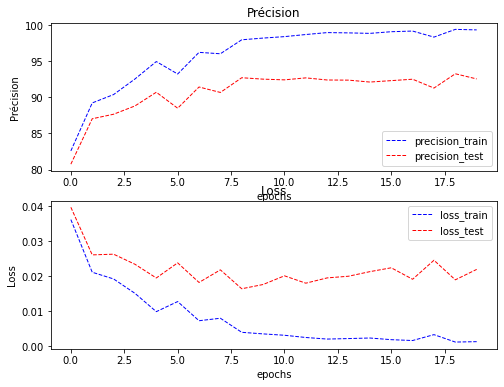

Finished Training
---Accuracy--- = 92.55412951895758
loss_train = [0.03620004640558272, 0.021127493371331112, 0.019209093886503843, 0.015093092486562163, 0.009843374159931414, 0.012732678176068924, 0.007246929328477959, 0.007957118392965097, 0.003930016115834094, 0.00347787804101006, 0.0030844059680833896, 0.0024462062292827462, 0.0019938898364560633, 0.0021381864127795907, 0.002295435874649953, 0.0018228406209644212, 0.0015769978337186912, 0.0032616280646333654, 0.0011379364400876059, 0.001251825723895409]
loss_test = [0.03972511943581173, 0.026100065269541867, 0.026295299979662748, 0.023413253571986686, 0.01948566038721529, 0.023814314670052898, 0.01820420591059791, 0.021810681853642454, 0.01639919506497142, 0.017615735829815505, 0.020102677827834956, 0.017995968986840277, 0.019508150278244946, 0.019987214919641182, 0.021298842836333685, 0.02240160387956965, 0.019117401861689417, 0.024558942255319842, 0.0189544291274019, 0.02194370609542302]
accuracy_train = [82.5895262822711, 89.229

In [ ]:
net = resnet18
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
train(net, optimizer, trainloader, testloader, criterion, n_epoch = 20,PATH = 'resnet18_without_ARCFACE_20_epoch_cropped',
      train_acc_period = 10,
      test_acc_period = 1000, cuda = use_cuda)

Finished Training
---Accuracy--- = 92.55412951895758
loss_train = [0.03620004640558272, 0.021127493371331112, 0.019209093886503843, 0.015093092486562163, 0.009843374159931414, 0.012732678176068924, 0.007246929328477959, 0.007957118392965097, 0.003930016115834094, 0.00347787804101006, 0.0030844059680833896, 0.0024462062292827462, 0.0019938898364560633, 0.0021381864127795907, 0.002295435874649953, 0.0018228406209644212, 0.0015769978337186912, 0.0032616280646333654, 0.0011379364400876059, 0.001251825723895409]
loss_test = [0.03972511943581173, 0.026100065269541867, 0.026295299979662748, 0.023413253571986686, 0.01948566038721529, 0.023814314670052898, 0.01820420591059791, 0.021810681853642454, 0.01639919506497142, 0.017615735829815505, 0.020102677827834956, 0.017995968986840277, 0.019508150278244946, 0.019987214919641182, 0.021298842836333685, 0.02240160387956965, 0.019117401861689417, 0.024558942255319842, 0.0189544291274019, 0.02194370609542302]
accuracy_train = [82.5895262822711, 89.22990251310439, 90.38847793073042, 92.54641649928966, 94.96154411404497, 93.23715279478763, 96.23524224758732, 96.04173810806839, 97.97677950325773, 98.21437319355313, 98.4152255915348, 98.706706510557, 98.97369323470338, 98.93450252290208, 98.86591877724979, 99.09616420908245, 99.18679273012296, 98.3490912653701, 99.41948758144319, 99.34845441630334]
accuracy_test = [80.74850592730479, 87.03830704418536, 87.66532771627314, 88.81159988243363, 90.71225629469971, 88.49808954638974, 91.43724894680122, 90.6828647006956, 92.72068188498089, 92.52473792495347, 92.42676594493975, 92.70108748897815, 92.407171548937, 92.38757715293426, 92.12305280689722, 92.31899676692466, 92.51494072695209, 91.29029097678064, 93.2693249730577, 92.55412951895758]

# Resnet18 without ARCFACE 2fc

In [ ]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, N_species),
            )

using cuda


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 0: precision_train = 78.08749326409641, cout_train = 0.04501252876397932, precision_test = 77.31948662682473, cout_test =0.046419884860252815
Saved model under resnet18_without_ARCFACE_20_epoch_cropped_2fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 1: precision_train = 88.71797384019987, cout_train = 0.023030050108591126, precision_test = 86.11737043205643, cout_test =0.02823806025897711
Saved model under resnet18_without_ARCFACE_20_epoch_cropped_2fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 2: precision_train = 87.58144319796209, cout_train = 0.024631328996574886, precision_test = 85.1964338199275, cout_test =0.02993786886576762
Saved model under resnet18_without_ARCFACE_20_epoch_cropped_2fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 3: precision_train = 90.706902464116, cout_train = 0.018520911604590722, precision_test = 87.5085725482512, cout_test =0.02571963542932558
Saved model under resnet18_without_ARCFACE_20_epoch_cropped_2fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 4: precision_train = 93.33023073531572, cout_train = 0.013255708420586142, precision_test = 89.63456451454884, cout_test =0.021546246111329104
Saved model under resnet18_without_ARCFACE_20_epoch_cropped_2fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 5: precision_train = 94.95174643609465, cout_train = 0.010131804086228312, precision_test = 90.96698344273538, cout_test =0.01845039174917967
Saved model under resnet18_without_ARCFACE_20_epoch_cropped_2fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 6: precision_train = 93.20041150247391, cout_train = 0.013541388292011408, precision_test = 88.38052317037328, cout_test =0.02465328720783272
Saved model under resnet18_without_ARCFACE_20_epoch_cropped_2fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 7: precision_train = 95.8947729388135, cout_train = 0.008095264905657628, precision_test = 91.2315077887724, cout_test =0.01928550315820065
Saved model under resnet18_without_ARCFACE_20_epoch_cropped_2fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 8: precision_train = 95.83843629059913, cout_train = 0.008395807422040215, precision_test = 90.42813755265993, cout_test =0.0225023350070155
Saved model under resnet18_without_ARCFACE_20_epoch_cropped_2fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 9: precision_train = 96.49488071327096, cout_train = 0.0069063196475736095, precision_test = 90.07543842461057, cout_test =0.022284077556552425
Saved model under resnet18_without_ARCFACE_20_epoch_cropped_2fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 10: precision_train = 96.91618086513496, cout_train = 0.005939820903550905, precision_test = 90.83961986871755, cout_test =0.02208605660305698
Saved model under resnet18_without_ARCFACE_20_epoch_cropped_2fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 11: precision_train = 98.35643952383285, cout_train = 0.0031419472754452794, precision_test = 92.50514352895073, cout_test =0.017942717384354434
Saved model under resnet18_without_ARCFACE_20_epoch_cropped_2fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 12: precision_train = 98.01107137608386, cout_train = 0.004025194742808015, precision_test = 91.71157049083962, cout_test =0.02081340827116959
Saved model under resnet18_without_ARCFACE_20_epoch_cropped_2fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 13: precision_train = 98.64547102336746, cout_train = 0.0027211010958988926, precision_test = 91.9956892328794, cout_test =0.019140322492743517
Saved model under resnet18_without_ARCFACE_20_epoch_cropped_2fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 14: precision_train = 98.51320237103806, cout_train = 0.002970838733831641, precision_test = 91.72136768884099, cout_test =0.020420520732350872
Saved model under resnet18_without_ARCFACE_20_epoch_cropped_2fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 15: precision_train = 98.49115759564982, cout_train = 0.003016831836200254, precision_test = 91.60380131282453, cout_test =0.021868947909695173
Saved model under resnet18_without_ARCFACE_20_epoch_cropped_2fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 16: precision_train = 98.62832508695439, cout_train = 0.0027219920399527225, precision_test = 91.52542372881356, cout_test =0.02166862580410454
Saved model under resnet18_without_ARCFACE_20_epoch_cropped_2fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 17: precision_train = 99.08391711164454, cout_train = 0.0018342011414344513, precision_test = 92.24061918291369, cout_test =0.022187799717867707
Saved model under resnet18_without_ARCFACE_20_epoch_cropped_2fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 18: precision_train = 99.08391711164454, cout_train = 0.001925675905748185, precision_test = 92.01528362888214, cout_test =0.021410820218891177
Saved model under resnet18_without_ARCFACE_20_epoch_cropped_2fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 19: precision_train = 99.23088228089942, cout_train = 0.0016234984108181361, precision_test = 91.84873126285882, cout_test =0.022156722207123856
Saved model under resnet18_without_ARCFACE_20_epoch_cropped_2fc


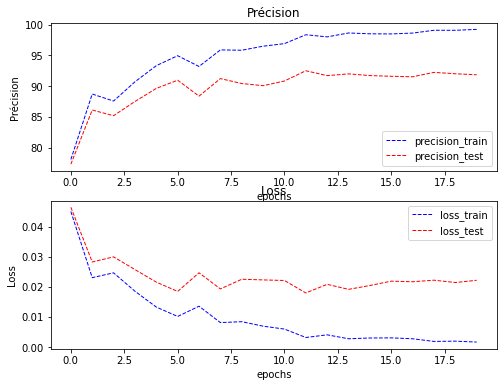

Finished Training
---Accuracy--- = 91.84873126285882
loss_train = [0.04501252876397932, 0.023030050108591126, 0.024631328996574886, 0.018520911604590722, 0.013255708420586142, 0.010131804086228312, 0.013541388292011408, 0.008095264905657628, 0.008395807422040215, 0.0069063196475736095, 0.005939820903550905, 0.0031419472754452794, 0.004025194742808015, 0.0027211010958988926, 0.002970838733831641, 0.003016831836200254, 0.0027219920399527225, 0.0018342011414344513, 0.001925675905748185, 0.0016234984108181361]
loss_test = [0.046419884860252815, 0.02823806025897711, 0.02993786886576762, 0.02571963542932558, 0.021546246111329104, 0.01845039174917967, 0.02465328720783272, 0.01928550315820065, 0.0225023350070155, 0.022284077556552425, 0.02208605660305698, 0.017942717384354434, 0.02081340827116959, 0.019140322492743517, 0.020420520732350872, 0.021868947909695173, 0.02166862580410454, 0.022187799717867707, 0.021410820218891177, 0.022156722207123856]
accuracy_train = [78.08749326409641, 88.717973

In [ ]:
net = resnet18
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
train(net, optimizer, trainloader, testloader, criterion, n_epoch = 20,PATH = 'resnet18_without_ARCFACE_20_epoch_cropped_2fc',
      train_acc_period = 10,
      test_acc_period = 1000, cuda = use_cuda)

# Resnet50 without ARCFACE 1fc

In [ ]:
resnet50 = models.resnet50(pretrained=True)
resnet50.fc = nn.Sequential(
            nn.Dropout(),
            nn.Linear(2048, N_species),
            )

using cuda


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 0: precision_train = 95.85803164649978, cout_train = 0.008311452611146365, precision_test = 94.46458312922505, cout_test =0.011259768020556558
Saved model under resnet18_without_ARCFACE_50_epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 1: precision_train = 97.26154901288395, cout_train = 0.005703251823853559, precision_test = 95.26795336533752, cout_test =0.009363489096777863
Saved model under resnet18_without_ARCFACE_50_epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 2: precision_train = 97.36932347033753, cout_train = 0.005297864025820746, precision_test = 94.56255510923876, cout_test =0.010694578590864005
Saved model under resnet18_without_ARCFACE_50_epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 3: precision_train = 98.69445941311909, cout_train = 0.003245852070272257, precision_test = 95.70882727539923, cout_test =0.008813899571269596
Saved model under resnet18_without_ARCFACE_50_epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 4: precision_train = 97.22480772057023, cout_train = 0.005453680705123214, precision_test = 93.81796806113452, cout_test =0.012319548911162107
Saved model under resnet18_without_ARCFACE_50_epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 5: precision_train = 98.54259540488904, cout_train = 0.0033084346632291945, precision_test = 95.12099539531694, cout_test =0.01047394770391594
Saved model under resnet18_without_ARCFACE_50_epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 6: precision_train = 98.35888894332044, cout_train = 0.0033713520213431605, precision_test = 94.4449887332223, cout_test =0.011807328049716381
Saved model under resnet18_without_ARCFACE_50_epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 7: precision_train = 98.17273306226424, cout_train = 0.003674735582260312, precision_test = 94.04330361516607, cout_test =0.012919144792528859
Saved model under resnet18_without_ARCFACE_50_epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 8: precision_train = 99.19169156909813, cout_train = 0.0017001956581539808, precision_test = 95.21896737533065, cout_test =0.010623269171043715
Saved model under resnet18_without_ARCFACE_50_epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 9: precision_train = 98.70180767158183, cout_train = 0.0025460688847599054, precision_test = 94.67032428725385, cout_test =0.012076795102788373
Saved model under resnet18_without_ARCFACE_50_epoch_cropped_1fc


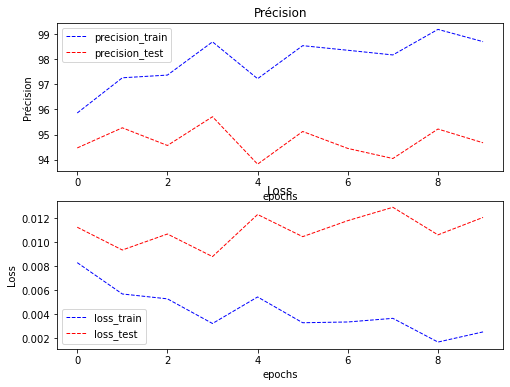

Finished Training
---Accuracy--- = 94.67032428725385
loss_train = [0.008311452611146365, 0.005703251823853559, 0.005297864025820746, 0.003245852070272257, 0.005453680705123214, 0.0033084346632291945, 0.0033713520213431605, 0.003674735582260312, 0.0017001956581539808, 0.0025460688847599054]
loss_test = [0.011259768020556558, 0.009363489096777863, 0.010694578590864005, 0.008813899571269596, 0.012319548911162107, 0.01047394770391594, 0.011807328049716381, 0.012919144792528859, 0.010623269171043715, 0.012076795102788373]
accuracy_train = [95.85803164649978, 97.26154901288395, 97.36932347033753, 98.69445941311909, 97.22480772057023, 98.54259540488904, 98.35888894332044, 98.17273306226424, 99.19169156909813, 98.70180767158183]
accuracy_test = [94.46458312922505, 95.26795336533752, 94.56255510923876, 95.70882727539923, 93.81796806113452, 95.12099539531694, 94.4449887332223, 94.04330361516607, 95.21896737533065, 94.67032428725385]


In [ ]:
PATH = 'resnet18_without_ARCFACE_50_epoch_cropped_1fc'
net = torch.load(PATH)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
train(net, optimizer, trainloader, testloader, criterion, n_epoch = 10,PATH = 'resnet18_without_ARCFACE_50_epoch_cropped_1fc',
      train_acc_period = 10,
      test_acc_period = 1000, cuda = use_cuda)
#commencé à 8 epochs
#Donc ici on est à 18 epochs

using cuda
Epoch:   0%|          | 0/20 [00:00<?, ?it/s]
Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]
Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]
Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]
Epoch 0: precision_train = 64.9953461029736, cout_train = 0.07374516919007792, precision_test = 63.82874497893602, cout_test =0.07754990829594095
Saved model under resnet18_without_ARCFACE_50_epoch_cropped_1fc
Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]
Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]
Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]
Epoch 1: precision_train = 82.77078332435212, cout_train = 0.03439150824100808, precision_test = 81.51268737141177, cout_test =0.03741030130972238
Saved model under resnet18_without_ARCFACE_50_epoch_cropped_1fc
Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]
Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]
Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]
Epoch 2: precision_train = 86.8000783814236, cout_train = 0.026777972254544615, precision_test = 84.18732242578622, cout_test =0.03135008236736955
Saved model under resnet18_without_ARCFACE_50_epoch_cropped_1fc
Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]
Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]
Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]
Epoch 3: precision_train = 88.1595061970313, cout_train = 0.023391988121600052, precision_test = 85.578524541981, cout_test =0.02858269113076093
Saved model under resnet18_without_ARCFACE_50_epoch_cropped_1fc
Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]
Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]
Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]
Epoch 4: precision_train = 90.7215989810415, cout_train = 0.017910437702034276, precision_test = 88.4393063583815, cout_test =0.023339178614299027
Saved model under resnet18_without_ARCFACE_50_epoch_cropped_1fc
Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]
Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]
Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]
Epoch 5: precision_train = 91.92671336893156, cout_train = 0.01597990035116261, precision_test = 89.0957186244734, cout_test =0.022223777060002888
Saved model under resnet18_without_ARCFACE_50_epoch_cropped_1fc
Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]
Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]
Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]
Epoch 6: precision_train = 91.99284769509626, cout_train = 0.016158187038699784, precision_test = 88.03762124032527, cout_test =0.02411690633214789
Saved model under resnet18_without_ARCFACE_50_epoch_cropped_1fc
Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]
Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]
Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]
Epoch 7: precision_train = 95.02767844020967, cout_train = 0.010018925609804297, precision_test = 90.9963750367395, cout_test =0.018709875154210888
Saved model under resnet18_without_ARCFACE_50_epoch_cropped_1fc
Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]
Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]
Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

# Resnet50 without ARCFACE 1fc with Freezing layers

In [ ]:
net = models.resnet50(pretrained=True)

for param in net.parameters(): #freeze the layers
    param.requires_grad = False

net.fc = nn.Sequential(
            nn.Dropout(),
            nn.Linear(2048, N_species),
            )


using cuda


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 0: precision_train = 82.06535051192867, cout_train = 0.03596464070866385, precision_test = 81.06201626334868, cout_test =0.03866039665363509
Saved model under resnet50_without_ARCFACE_10_epoch_cropped_1fc_freeze


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 1: precision_train = 84.28452456767747, cout_train = 0.03209636313624033, precision_test = 82.69814832957773, cout_test =0.0357553327571631
Saved model under resnet50_without_ARCFACE_10_epoch_cropped_1fc_freeze


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 2: precision_train = 84.4118943810317, cout_train = 0.03200765159678676, precision_test = 83.07044185362986, cout_test =0.0360945483080753
Saved model under resnet50_without_ARCFACE_10_epoch_cropped_1fc_freeze


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 3: precision_train = 85.47739185812962, cout_train = 0.02967706432984236, precision_test = 83.95218967375331, cout_test =0.03385094158695227
Saved model under resnet50_without_ARCFACE_10_epoch_cropped_1fc_freeze


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 4: precision_train = 86.18772350952824, cout_train = 0.027897856841914544, precision_test = 84.13833643577937, cout_test =0.03262758227193859
Saved model under resnet50_without_ARCFACE_10_epoch_cropped_1fc_freeze


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 5: precision_train = 84.451085092833, cout_train = 0.030947676222451672, precision_test = 83.09983344763398, cout_test =0.035524351489296314
Saved model under resnet50_without_ARCFACE_10_epoch_cropped_1fc_freeze


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 6: precision_train = 85.80316464997796, cout_train = 0.028690805284216345, precision_test = 84.2657000097972, cout_test =0.03372218605104268
Saved model under resnet50_without_ARCFACE_10_epoch_cropped_1fc_freeze


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 7: precision_train = 84.661735168765, cout_train = 0.03129931913641969, precision_test = 82.66875673557362, cout_test =0.03720934511850043
Saved model under resnet50_without_ARCFACE_10_epoch_cropped_1fc_freeze


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 8: precision_train = 86.47675500906286, cout_train = 0.02744529460771375, precision_test = 84.471441167826, cout_test =0.03280209911839554
Saved model under resnet50_without_ARCFACE_10_epoch_cropped_1fc_freeze


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 9: precision_train = 86.33713809827071, cout_train = 0.02922274985843453, precision_test = 84.22651121779171, cout_test =0.03452461140462604
Saved model under resnet50_without_ARCFACE_10_epoch_cropped_1fc_freeze


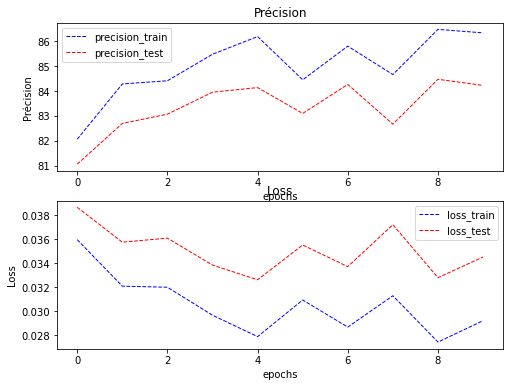

Finished Training
---Accuracy--- = 84.22651121779171
loss_train = [0.03596464070866385, 0.03209636313624033, 0.03200765159678676, 0.02967706432984236, 0.027897856841914544, 0.030947676222451672, 0.028690805284216345, 0.03129931913641969, 0.02744529460771375, 0.02922274985843453]
loss_test = [0.03866039665363509, 0.0357553327571631, 0.0360945483080753, 0.03385094158695227, 0.03262758227193859, 0.035524351489296314, 0.03372218605104268, 0.03720934511850043, 0.03280209911839554, 0.03452461140462604]
accuracy_train = [82.06535051192867, 84.28452456767747, 84.4118943810317, 85.47739185812962, 86.18772350952824, 84.451085092833, 85.80316464997796, 84.661735168765, 86.47675500906286, 86.33713809827071]
accuracy_test = [81.06201626334868, 82.69814832957773, 83.07044185362986, 83.95218967375331, 84.13833643577937, 83.09983344763398, 84.2657000097972, 82.66875673557362, 84.471441167826, 84.22651121779171]


In [ ]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()),lr=learning_rate)
train(net, optimizer, trainloader, testloader, criterion, n_epoch = 10,PATH = 'resnet50_without_ARCFACE_10_epoch_cropped_1fc_freeze',
      train_acc_period = 10,
      test_acc_period = 1000, cuda = use_cuda)

# Resnet50 without ARCFACE 2fc with Freezing layers (little better than 1fc)

In [ ]:
net = models.resnet50(pretrained=True)

for param in net.parameters(): #freeze the layers
    param.requires_grad = False

net.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, N_species)
            )


using cuda


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 0: precision_train = 81.06353794150786, cout_train = 0.03838478510718752, precision_test = 79.94513569119232, cout_test =0.040902076747282676
Saved model under resnet50_without_ARCFACE_10_epoch_cropped_2fc_freeze


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 1: precision_train = 84.1081663645716, cout_train = 0.033239563241325785, precision_test = 82.8549034975997, cout_test =0.036116658128995824
Saved model under resnet50_without_ARCFACE_10_epoch_cropped_2fc_freeze


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 2: precision_train = 84.6347915544016, cout_train = 0.030385043378978675, precision_test = 83.16841383364358, cout_test =0.033540741351161286
Saved model under resnet50_without_ARCFACE_10_epoch_cropped_2fc_freeze


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 3: precision_train = 85.57781805712047, cout_train = 0.02870636750655022, precision_test = 84.28529440579995, cout_test =0.03204442790095458
Saved model under resnet50_without_ARCFACE_10_epoch_cropped_2fc_freeze


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 4: precision_train = 87.14544652917259, cout_train = 0.025494189134020646, precision_test = 85.4413637699618, cout_test =0.029445097406980654
Saved model under resnet50_without_ARCFACE_10_epoch_cropped_2fc_freeze


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 5: precision_train = 86.73149463577133, cout_train = 0.02630230035703657, precision_test = 84.76535710786715, cout_test =0.03126323413429741
Saved model under resnet50_without_ARCFACE_10_epoch_cropped_2fc_freeze


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 6: precision_train = 85.48963895556753, cout_train = 0.028431701327991908, precision_test = 83.86401489174096, cout_test =0.03321419447529785
Saved model under resnet50_without_ARCFACE_10_epoch_cropped_2fc_freeze


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 7: precision_train = 87.94150786263656, cout_train = 0.024230473627795436, precision_test = 85.75487410600569, cout_test =0.029279004138806512
Saved model under resnet50_without_ARCFACE_10_epoch_cropped_2fc_freeze


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 8: precision_train = 88.13991084113066, cout_train = 0.023614133032145476, precision_test = 85.68629371999609, cout_test =0.028952079200176437
Saved model under resnet50_without_ARCFACE_10_epoch_cropped_2fc_freeze


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 9: precision_train = 87.9611032185372, cout_train = 0.02394599482115623, precision_test = 85.35318898794945, cout_test =0.029407726401307854
Saved model under resnet50_without_ARCFACE_10_epoch_cropped_2fc_freeze


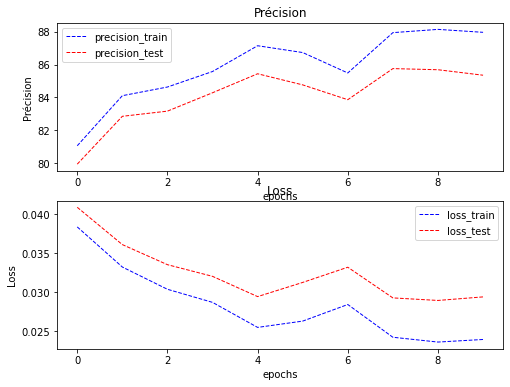

Finished Training
---Accuracy--- = 85.35318898794945
loss_train = [0.03838478510718752, 0.033239563241325785, 0.030385043378978675, 0.02870636750655022, 0.025494189134020646, 0.02630230035703657, 0.028431701327991908, 0.024230473627795436, 0.023614133032145476, 0.02394599482115623]
loss_test = [0.040902076747282676, 0.036116658128995824, 0.033540741351161286, 0.03204442790095458, 0.029445097406980654, 0.03126323413429741, 0.03321419447529785, 0.029279004138806512, 0.028952079200176437, 0.029407726401307854]
accuracy_train = [81.06353794150786, 84.1081663645716, 84.6347915544016, 85.57781805712047, 87.14544652917259, 86.73149463577133, 85.48963895556753, 87.94150786263656, 88.13991084113066, 87.9611032185372]
accuracy_test = [79.94513569119232, 82.8549034975997, 83.16841383364358, 84.28529440579995, 85.4413637699618, 84.76535710786715, 83.86401489174096, 85.75487410600569, 85.68629371999609, 85.35318898794945]


In [ ]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()),lr=learning_rate)
train(net, optimizer, trainloader, testloader, criterion, n_epoch = 10,PATH = 'resnet50_without_ARCFACE_10_epoch_cropped_2fc_freeze',
      train_acc_period = 10,
      test_acc_period = 1000, cuda = use_cuda)

# EFFNET B7 species

In [ ]:
net = models.efficientnet_b7(pretrained=True)
net

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivatio

In [ ]:
net.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(2560, N_species),
            )

using cuda


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 0: precision_train = 85.6904913535492, cout_train = 0.031926557707598426, precision_test = 84.06975604976977, cout_test =0.03717128842555558
Saved model under EFFNET_b7_species_20_epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 1: precision_train = 92.98731200705433, cout_train = 0.014256018640974026, precision_test = 90.46732634466542, cout_test =0.02025837991476983
Saved model under EFFNET_b7_species_20_epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 2: precision_train = 94.24876304315877, cout_train = 0.012743369859433265, precision_test = 91.3392769667875, cout_test =0.020396659565692307
Saved model under EFFNET_b7_species_20_epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 3: precision_train = 95.39754078283447, cout_train = 0.009064608677178327, precision_test = 92.71088468697953, cout_test =0.0162737697689265
Saved model under EFFNET_b7_species_20_epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 4: precision_train = 95.33630529564493, cout_train = 0.010241042703120866, precision_test = 92.00548643088077, cout_test =0.018867429570513378
Saved model under EFFNET_b7_species_20_epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 5: precision_train = 96.54876794199775, cout_train = 0.006929320330194931, precision_test = 93.21054178504947, cout_test =0.015556588207055808
Saved model under EFFNET_b7_species_20_epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 6: precision_train = 97.80532013912703, cout_train = 0.0042616935212457475, precision_test = 94.42539433721956, cout_test =0.012956201799589558
Saved model under EFFNET_b7_species_20_epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 7: precision_train = 97.04600009797677, cout_train = 0.005904298578960897, precision_test = 93.25952777505633, cout_test =0.01589645057077583
Saved model under EFFNET_b7_species_20_epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 8: precision_train = 98.08210454122373, cout_train = 0.003711538389286947, precision_test = 94.31762515920447, cout_test =0.013601170828366286
Saved model under EFFNET_b7_species_20_epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 9: precision_train = 97.43545779650223, cout_train = 0.0053873174392995, precision_test = 93.18115019104536, cout_test =0.01739841092839691
Saved model under EFFNET_b7_species_20_epoch_cropped_1fc


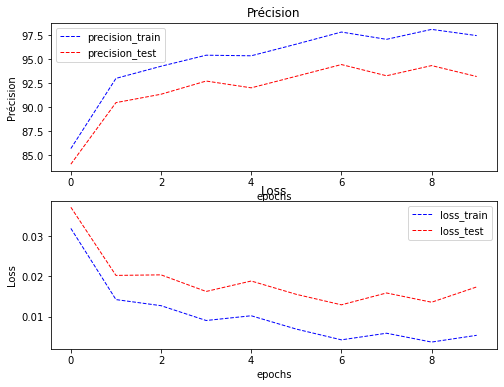

Finished Training
---Accuracy--- = 93.18115019104536
loss_train = [0.031926557707598426, 0.014256018640974026, 0.012743369859433265, 0.009064608677178327, 0.010241042703120866, 0.006929320330194931, 0.0042616935212457475, 0.005904298578960897, 0.003711538389286947, 0.0053873174392995]
loss_test = [0.03717128842555558, 0.02025837991476983, 0.020396659565692307, 0.0162737697689265, 0.018867429570513378, 0.015556588207055808, 0.012956201799589558, 0.01589645057077583, 0.013601170828366286, 0.01739841092839691]
accuracy_train = [85.6904913535492, 92.98731200705433, 94.24876304315877, 95.39754078283447, 95.33630529564493, 96.54876794199775, 97.80532013912703, 97.04600009797677, 98.08210454122373, 97.43545779650223]
accuracy_test = [84.06975604976977, 90.46732634466542, 91.3392769667875, 92.71088468697953, 92.00548643088077, 93.21054178504947, 94.42539433721956, 93.25952777505633, 94.31762515920447, 93.18115019104536]


In [ ]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()),lr=learning_rate)
train(net, optimizer, trainloader, testloader, criterion, n_epoch = 10,PATH = 'EFFNET_b7_species_10_epoch_cropped_1fc',
      train_acc_period = 10,
      test_acc_period = 1000, cuda = use_cuda)

# Alexnet

In [ ]:
net = models.alexnet(pretrained=True)
net.classifier = nn.Sequential(
        nn.Dropout(p=0.5, inplace=False),
        nn.Linear(in_features=9216, out_features=4096, bias=True),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5, inplace=False),
        nn.Linear(in_features=4096, out_features=4096, bias=True),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=4096, out_features=N_species, bias=True)
        )


using cuda


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/2042 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2042 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch 0: precision_train = 18.937538273116964, cout_train = 0.1653524987550141, precision_test = 18.9321577271614, cout_test =0.16540558419039575
Saved model under Alexnet_species_10_epoch_cropped_1fc


Processing epoch:   0%|          | 0/2042 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2042 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch 1: precision_train = 18.937538273116964, cout_train = 0.16508785780412027, precision_test = 18.9321577271614, cout_test =0.1651984894944265
Saved model under Alexnet_species_10_epoch_cropped_1fc


Processing epoch:   0%|          | 0/2042 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2042 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch 2: precision_train = 18.937538273116964, cout_train = 0.1651714421311406, precision_test = 18.9321577271614, cout_test =0.16531435931806263
Saved model under Alexnet_species_10_epoch_cropped_1fc


Processing epoch:   0%|          | 0/2042 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2042 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch 3: precision_train = 18.937538273116964, cout_train = 0.16502751113079256, precision_test = 18.9321577271614, cout_test =0.1652518725558703
Saved model under Alexnet_species_10_epoch_cropped_1fc


Processing epoch:   0%|          | 0/2042 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2042 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/511 [00:00<?, ?it/s]

Epoch 4: precision_train = 18.937538273116964, cout_train = 0.16514108155814694, precision_test = 18.9321577271614, cout_test =0.16524593921493672
Saved model under Alexnet_species_10_epoch_cropped_1fc


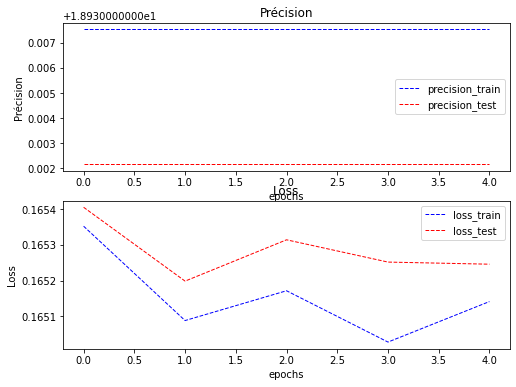

Finished Training
---Accuracy--- = 18.9321577271614
loss_train = [0.1653524987550141, 0.16508785780412027, 0.1651714421311406, 0.16502751113079256, 0.16514108155814694]
loss_test = [0.16540558419039575, 0.1651984894944265, 0.16531435931806263, 0.1652518725558703, 0.16524593921493672]
accuracy_train = [18.937538273116964, 18.937538273116964, 18.937538273116964, 18.937538273116964, 18.937538273116964]
accuracy_test = [18.9321577271614, 18.9321577271614, 18.9321577271614, 18.9321577271614, 18.9321577271614]


In [ ]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
train(net, optimizer, trainloader, testloader, criterion, n_epoch = 5,PATH = 'Alexnet_species_10_epoch_cropped_1fc',
      train_acc_period = 10,
      test_acc_period = 1000, cuda = use_cuda)

# VGG19_bn

In [ ]:
# net = models.alexnet(pretrained=True)
# net.classifier = nn.Sequential(
#         nn.Dropout(p=0.5, inplace=False),
#         nn.Linear(in_features=9216, out_features=4096, bias=True),
#         nn.ReLU(inplace=True),
#         nn.Dropout(p=0.5, inplace=False),
#         nn.Linear(in_features=4096, out_features=4096, bias=True),
#         nn.ReLU(inplace=True),
#         nn.Linear(in_features=4096, out_features=N_species, bias=True)
#         )

In [ ]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()),lr=learning_rate)
train(net, optimizer, trainloader, testloader, criterion, n_epoch = 10,PATH = 'VGG19_bn_species_10_epoch_cropped_1fc',
      train_acc_period = 10,
      test_acc_period = 1000, cuda = use_cuda)

# For species

# Resnet18 with ARCFACE cropped
Epoch 0: precision_train = 76.54190956743251, cout_train = 0.05541610362161784, precision_test = 75.14450867052022, cout_test =0.05816009863911804


# Resnet18 without ARCFACE 1fc cropped

Epoch 0: precision_train = 82.46950472737961, cout_train = 0.035432406041926476, precision_test = 81.02282747134319, cout_test =0.039522438330069055

# Bilan Species : ResNet50 sans freeze avec 1 fc est le meilleur modele

# Maintenant les individus

# RESNET50 30 epochs, crop dataset, not augmented, pretrained on species

In [ ]:
PATH = 'resnet50_without_ARCFACE_species_epoch_cropped_1fc'
net = torch.load(PATH)
net.fc = nn.Sequential(
            nn.Dropout(),
            nn.Linear(2048, N_individus),
            )

using cuda


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 0: precision_train = 8.658697888600402, cout_train = 0.4657097476446628, precision_test = 7.504653669050652, cout_test =0.49446552311555403
Saved model under resnet50_without_ARCFACE_individuals_30epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 1: precision_train = 12.215254984568658, cout_train = 0.431272568628181, precision_test = 9.826589595375722, cout_test =0.485496316236883
Saved model under resnet50_without_ARCFACE_individuals_30epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 2: precision_train = 15.9187772497918, cout_train = 0.39090754344241085, precision_test = 12.18771431370628, cout_test =0.485922455051871
Saved model under resnet50_without_ARCFACE_individuals_30epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 3: precision_train = 22.385244697006808, cout_train = 0.35353199791383844, precision_test = 14.62721661604781, cout_test =0.4902418287865291
Saved model under resnet50_without_ARCFACE_individuals_30epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 4: precision_train = 30.223387057267427, cout_train = 0.3154724151332603, precision_test = 16.194768296267267, cout_test =0.49236942241553217
Saved model under resnet50_without_ARCFACE_individuals_30epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 5: precision_train = 40.844069955420565, cout_train = 0.2722347851497542, precision_test = 17.12550210639757, cout_test =0.5047866675626452
Saved model under resnet50_without_ARCFACE_individuals_30epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 6: precision_train = 55.84186547788174, cout_train = 0.218870870765009, precision_test = 18.252179876555306, cout_test =0.5166154126409944
Saved model under resnet50_without_ARCFACE_individuals_30epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 7: precision_train = 75.51805222162348, cout_train = 0.15382562825261994, precision_test = 20.10385029881454, cout_test =0.524800291161375
Saved model under resnet50_without_ARCFACE_individuals_30epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 8: precision_train = 89.14662225052662, cout_train = 0.09413141771083026, precision_test = 21.161947682962673, cout_test =0.5510500423632839
Saved model under resnet50_without_ARCFACE_individuals_30epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 9: precision_train = 94.26835839905942, cout_train = 0.05750232227998882, precision_test = 21.975115117076516, cout_test =0.5861876051304704
Saved model under resnet50_without_ARCFACE_individuals_30epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 10: precision_train = 96.46793709890756, cout_train = 0.040502197469272985, precision_test = 22.8078769471931, cout_test =0.6152092687084145
Saved model under resnet50_without_ARCFACE_individuals_30epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 11: precision_train = 97.5848723852447, cout_train = 0.03304493291499607, precision_test = 21.75957676104634, cout_test =0.6229442457406705
Saved model under resnet50_without_ARCFACE_individuals_30epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 12: precision_train = 98.99818742957919, cout_train = 0.021736254579751136, precision_test = 23.27814245125894, cout_test =0.6477856384478039
Saved model under resnet50_without_ARCFACE_individuals_30epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 13: precision_train = 99.2872189291138, cout_train = 0.01760287619218371, precision_test = 23.131184481238368, cout_test =0.6452805894332382
Saved model under resnet50_without_ARCFACE_individuals_30epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 14: precision_train = 99.48072306863273, cout_train = 0.013692095967946141, precision_test = 22.925443323209564, cout_test =0.6725240063921903
Saved model under resnet50_without_ARCFACE_individuals_30epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 15: precision_train = 99.82364179689414, cout_train = 0.009264085650061381, precision_test = 23.27814245125894, cout_test =0.6853680028800482
Saved model under resnet50_without_ARCFACE_individuals_30epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 16: precision_train = 99.85548425023269, cout_train = 0.007684062521108386, precision_test = 23.023415303223278, cout_test =0.6839720930725678
Saved model under resnet50_without_ARCFACE_individuals_30epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 17: precision_train = 99.91671973742223, cout_train = 0.0052856230247702455, precision_test = 23.52307240129323, cout_test =0.6933526752206947
Saved model under resnet50_without_ARCFACE_individuals_30epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 18: precision_train = 99.92651741537256, cout_train = 0.00513225226014257, precision_test = 22.866660135201332, cout_test =0.7044288849309737
Saved model under resnet50_without_ARCFACE_individuals_30epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 19: precision_train = 99.91427031793465, cout_train = 0.004992581993839409, precision_test = 22.6021357891643, cout_test =0.7235661139740023
Saved model under resnet50_without_ARCFACE_individuals_30epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 20: precision_train = 99.92406799588497, cout_train = 0.0033466515472901524, precision_test = 23.924757519349466, cout_test =0.73792885183015
Saved model under resnet50_without_ARCFACE_individuals_30epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 21: precision_train = 99.92896683486013, cout_train = 0.003441476280926316, precision_test = 23.82678553933575, cout_test =0.737656157970008
Saved model under resnet50_without_ARCFACE_individuals_30epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 22: precision_train = 99.95591044922354, cout_train = 0.0022955974543411206, precision_test = 23.091995689232878, cout_test =0.7536228757256379
Saved model under resnet50_without_ARCFACE_individuals_30epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 23: precision_train = 99.95101161024837, cout_train = 0.002747204570585413, precision_test = 23.121387283236995, cout_test =0.7475779760803032
Saved model under resnet50_without_ARCFACE_individuals_30epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 24: precision_train = 99.95835986871111, cout_train = 0.0023593703808682267, precision_test = 23.787596747330262, cout_test =0.7479683304318862
Saved model under resnet50_without_ARCFACE_individuals_30epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 25: precision_train = 99.9608092881987, cout_train = 0.0029999676671464584, precision_test = 23.356520035269913, cout_test =0.7734700613394649
Saved model under resnet50_without_ARCFACE_individuals_30epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 26: precision_train = 99.9608092881987, cout_train = 0.0017655966024501628, precision_test = 23.444694817282258, cout_test =0.7486431439125866
Saved model under resnet50_without_ARCFACE_individuals_30epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 27: precision_train = 99.96570812717385, cout_train = 0.001524645499691551, precision_test = 23.924757519349466, cout_test =0.7372733183235055
Saved model under resnet50_without_ARCFACE_individuals_30epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 28: precision_train = 99.96815754666144, cout_train = 0.0019928005478550997, precision_test = 23.611247183305576, cout_test =0.7401871925541618
Saved model under resnet50_without_ARCFACE_individuals_30epoch_cropped_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 29: precision_train = 99.97060696614902, cout_train = 0.0017011682487206505, precision_test = 22.896051729205446, cout_test =0.7768086398092834
Saved model under resnet50_without_ARCFACE_individuals_30epoch_cropped_1fc


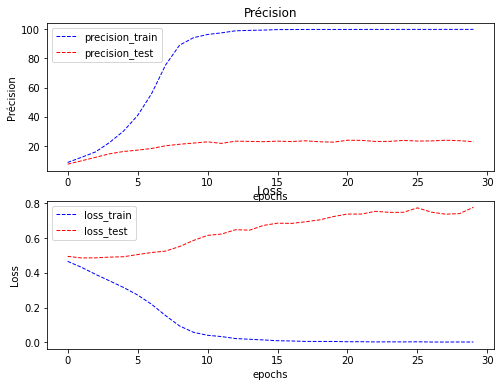

Finished Training
---Accuracy--- = 22.896051729205446
loss_train = [0.4657097476446628, 0.431272568628181, 0.39090754344241085, 0.35353199791383844, 0.3154724151332603, 0.2722347851497542, 0.218870870765009, 0.15382562825261994, 0.09413141771083026, 0.05750232227998882, 0.040502197469272985, 0.03304493291499607, 0.021736254579751136, 0.01760287619218371, 0.013692095967946141, 0.009264085650061381, 0.007684062521108386, 0.0052856230247702455, 0.00513225226014257, 0.004992581993839409, 0.0033466515472901524, 0.003441476280926316, 0.0022955974543411206, 0.002747204570585413, 0.0023593703808682267, 0.0029999676671464584, 0.0017655966024501628, 0.001524645499691551, 0.0019928005478550997, 0.0017011682487206505]
loss_test = [0.49446552311555403, 0.485496316236883, 0.485922455051871, 0.4902418287865291, 0.49236942241553217, 0.5047866675626452, 0.5166154126409944, 0.524800291161375, 0.5510500423632839, 0.5861876051304704, 0.6152092687084145, 0.6229442457406705, 0.6477856384478039, 0.6452805894

In [ ]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
top5train(net, optimizer, trainloader, testloader, criterion, n_epoch = 30,PATH = 'resnet50_without_ARCFACE_individuals_30epoch_cropped_1fc',
      train_acc_period = 10,
      test_acc_period = 1000, cuda = use_cuda)

# Augmentation = 2

# RESNET50 10 epochs, crop dataset, naive AUGMENTION, pretrained on species

In [ ]:
PATH = 'resnet50_without_ARCFACE_species_epoch_cropped_1fc'
net = torch.load(PATH)
net.fc = nn.Sequential(
            nn.Dropout(),
            nn.Linear(2048, N_individus),
            )

using cuda


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/1276 [00:00<?, ?it/s]

Epoch 0: precision_train = 8.923235193259197, cout_train = 0.45538717562334846, precision_test = 8.107181346135006, cout_test =0.47918441887290536
Saved model under resnet50_without_ARCFACE_individuals_10epoch_cropped_AUGMENTED_1fc


Processing epoch:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/1276 [00:00<?, ?it/s]

Epoch 1: precision_train = 12.986822123156811, cout_train = 0.41477815476401986, precision_test = 11.354952483589694, cout_test =0.455750804345942
Saved model under resnet50_without_ARCFACE_individuals_10epoch_cropped_AUGMENTED_1fc


Processing epoch:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/1276 [00:00<?, ?it/s]

Epoch 2: precision_train = 18.523734874834663, cout_train = 0.36646111908626133, precision_test = 14.75458019006564, cout_test =0.4279380664076104
Saved model under resnet50_without_ARCFACE_individuals_10epoch_cropped_AUGMENTED_1fc


Processing epoch:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/1276 [00:00<?, ?it/s]

Epoch 3: precision_train = 25.49355802674766, cout_train = 0.32695895747902964, precision_test = 18.639169197609483, cout_test =0.409778486634721
Saved model under resnet50_without_ARCFACE_individuals_10epoch_cropped_AUGMENTED_1fc


Processing epoch:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/1276 [00:00<?, ?it/s]

Epoch 4: precision_train = 38.38362808014501, cout_train = 0.27744007429452666, precision_test = 23.444694817282258, cout_test =0.38174658123211447
Saved model under resnet50_without_ARCFACE_individuals_10epoch_cropped_AUGMENTED_1fc


Processing epoch:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/1276 [00:00<?, ?it/s]

Epoch 5: precision_train = 55.61774359476804, cout_train = 0.22594419262337145, precision_test = 28.887038307044186, cout_test =0.35382524400473553
Saved model under resnet50_without_ARCFACE_individuals_10epoch_cropped_AUGMENTED_1fc


Processing epoch:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/1276 [00:00<?, ?it/s]

Epoch 6: precision_train = 70.85190809778082, cout_train = 0.16612207312212623, precision_test = 35.847947487018715, cout_test =0.32379618951923245
Saved model under resnet50_without_ARCFACE_individuals_10epoch_cropped_AUGMENTED_1fc


Processing epoch:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/1276 [00:00<?, ?it/s]

Epoch 7: precision_train = 79.26811345711066, cout_train = 0.12017707754365783, precision_test = 43.60242970510434, cout_test =0.2928964081690689
Saved model under resnet50_without_ARCFACE_individuals_10epoch_cropped_AUGMENTED_1fc


Processing epoch:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/1276 [00:00<?, ?it/s]

Epoch 8: precision_train = 84.44373683437026, cout_train = 0.09536513157452782, precision_test = 52.17007935730381, cout_test =0.26000026891803113
Saved model under resnet50_without_ARCFACE_individuals_10epoch_cropped_AUGMENTED_1fc


Processing epoch:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/1276 [00:00<?, ?it/s]

Epoch 9: precision_train = 86.82457257629942, cout_train = 0.08331917312188025, precision_test = 56.779661016949156, cout_test =0.25057974937462696
Saved model under resnet50_without_ARCFACE_individuals_10epoch_cropped_AUGMENTED_1fc


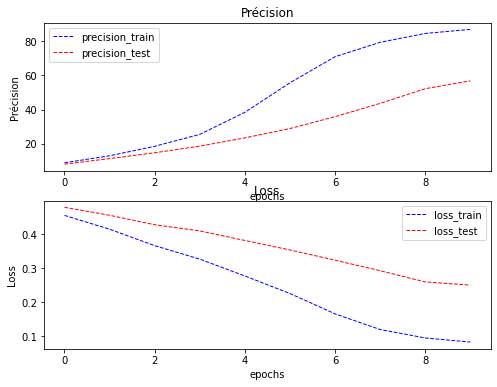

Finished Training
---Accuracy--- = 56.779661016949156
loss_train = [0.45538717562334846, 0.41477815476401986, 0.36646111908626133, 0.32695895747902964, 0.27744007429452666, 0.22594419262337145, 0.16612207312212623, 0.12017707754365783, 0.09536513157452782, 0.08331917312188025]
loss_test = [0.47918441887290536, 0.455750804345942, 0.4279380664076104, 0.409778486634721, 0.38174658123211447, 0.35382524400473553, 0.32379618951923245, 0.2928964081690689, 0.26000026891803113, 0.25057974937462696]
accuracy_train = [8.923235193259197, 12.986822123156811, 18.523734874834663, 25.49355802674766, 38.38362808014501, 55.61774359476804, 70.85190809778082, 79.26811345711066, 84.44373683437026, 86.82457257629942]
accuracy_test = [8.107181346135006, 11.354952483589694, 14.75458019006564, 18.639169197609483, 23.444694817282258, 28.887038307044186, 35.847947487018715, 43.60242970510434, 52.17007935730381, 56.779661016949156]


In [ ]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
top5train(net, optimizer, trainloader, testloader, criterion, n_epoch = 10,PATH = 'resnet50_without_ARCFACE_individuals_10epoch_cropped_AUGMENTED_1fc',
      train_acc_period = 10,
      test_acc_period = 1000, cuda = use_cuda)

# RESNET50 10 epochs, crop dataset, stratified and honest AUGMENTION, pretrained on species

In [ ]:
PATH = 'resnet50_without_ARCFACE_species_epoch_cropped_1fc'
net = torch.load(PATH)
net.fc = nn.Sequential(
            nn.Dropout(),
            nn.Linear(2048, N_individus),
            )

using cuda


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 0: precision_train = 9.30289521383432, cout_train = 0.4554509658556055, precision_test = 8.366807093171353, cout_test =0.5057033305421823
Saved model under resnet50_without_ARCFACE_individuals_10epoch_cropped_FAIR_AUGMENTED_1fc


Processing epoch:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 1: precision_train = 14.08661147308088, cout_train = 0.4038089559037688, precision_test = 10.963064563534829, cout_test =0.5068421177431011
Saved model under resnet50_without_ARCFACE_individuals_10epoch_cropped_FAIR_AUGMENTED_1fc


Processing epoch:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 2: precision_train = 20.32895703718219, cout_train = 0.3547963618630671, precision_test = 13.451552855883218, cout_test =0.5135098934126867
Saved model under resnet50_without_ARCFACE_individuals_10epoch_cropped_FAIR_AUGMENTED_1fc


Processing epoch:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 3: precision_train = 29.505707147406063, cout_train = 0.32397521975249155, precision_test = 15.714705594200058, cout_test =0.543184136321265
Saved model under resnet50_without_ARCFACE_individuals_10epoch_cropped_FAIR_AUGMENTED_1fc


Processing epoch:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 4: precision_train = 44.94684759711948, cout_train = 0.25476046950347697, precision_test = 18.261977074556675, cout_test =0.5425319574927331
Saved model under resnet50_without_ARCFACE_individuals_10epoch_cropped_FAIR_AUGMENTED_1fc


Processing epoch:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 5: precision_train = 69.12261793954832, cout_train = 0.1674306790510899, precision_test = 20.025472714803566, cout_test =0.5210910859065458
Saved model under resnet50_without_ARCFACE_individuals_10epoch_cropped_FAIR_AUGMENTED_1fc


Processing epoch:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 6: precision_train = 81.91103708421105, cout_train = 0.10971796082843993, precision_test = 21.828157147055943, cout_test =0.568040448303985
Saved model under resnet50_without_ARCFACE_individuals_10epoch_cropped_FAIR_AUGMENTED_1fc


Processing epoch:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 7: precision_train = 87.20545730661833, cout_train = 0.08366698525327351, precision_test = 23.22915646125208, cout_test =0.5912903882595962
Saved model under resnet50_without_ARCFACE_individuals_10epoch_cropped_FAIR_AUGMENTED_1fc


Processing epoch:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 8: precision_train = 90.87836182824671, cout_train = 0.0650905016650018, precision_test = 24.140295875379643, cout_test =0.6008271715532872
Saved model under resnet50_without_ARCFACE_individuals_10epoch_cropped_FAIR_AUGMENTED_1fc


Processing epoch:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/5104 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 9: precision_train = 92.63949443981777, cout_train = 0.053777632663007384, precision_test = 24.355834231409816, cout_test =0.6361450638607081
Saved model under resnet50_without_ARCFACE_individuals_10epoch_cropped_FAIR_AUGMENTED_1fc


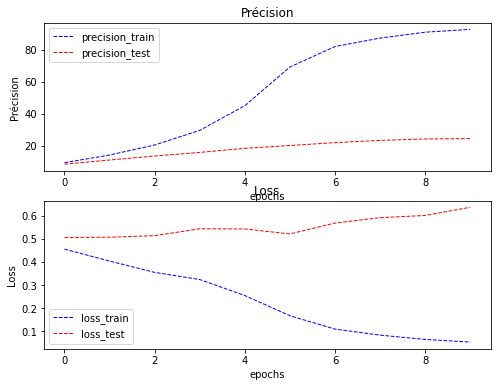

Finished Training
---Accuracy--- = 24.355834231409816
loss_train = [0.4554509658556055, 0.4038089559037688, 0.3547963618630671, 0.32397521975249155, 0.25476046950347697, 0.1674306790510899, 0.10971796082843993, 0.08366698525327351, 0.0650905016650018, 0.053777632663007384]
loss_test = [0.5057033305421823, 0.5068421177431011, 0.5135098934126867, 0.543184136321265, 0.5425319574927331, 0.5210910859065458, 0.568040448303985, 0.5912903882595962, 0.6008271715532872, 0.6361450638607081]
accuracy_train = [9.30289521383432, 14.08661147308088, 20.32895703718219, 29.505707147406063, 44.94684759711948, 69.12261793954832, 81.91103708421105, 87.20545730661833, 90.87836182824671, 92.63949443981777]
accuracy_test = [8.366807093171353, 10.963064563534829, 13.451552855883218, 15.714705594200058, 18.261977074556675, 20.025472714803566, 21.828157147055943, 23.22915646125208, 24.140295875379643, 24.355834231409816]


In [ ]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
top5train(net, optimizer, trainloader, testloader, criterion, n_epoch = 10,PATH = 'resnet50_without_ARCFACE_individuals_10epoch_cropped_FAIR_AUGMENTED_1fc',
      train_acc_period = 10,
      test_acc_period = 1000, cuda = use_cuda)

# RESNET50 with ARCFACE, 10 epochs, crop dataset, no AUGMENTION, pretrained on species

In [ ]:
PATH = 'resnet50_without_ARCFACE_species_epoch_cropped_1fc'
net = torch.load(PATH)
net.fc = nn.Sequential(
            nn.Dropout(),
            MyArcFaceClassifier(2048, N_individus)
            )

using cuda


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 0: precision_train = 1.9864792044285504, cout_train = 0.5921185457308756, precision_test = 1.8908592142647203, cout_test =0.5945260387169131
Saved model under resnet50_without_ARCFACE_individuals_10epoch_cropped_FAIR_AUGMENTED_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 1: precision_train = 1.9864792044285504, cout_train = 0.5900331126103611, precision_test = 1.8908592142647203, cout_test =0.5934804201803491
Saved model under resnet50_without_ARCFACE_individuals_10epoch_cropped_FAIR_AUGMENTED_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 2: precision_train = 1.9864792044285504, cout_train = 0.5873137058121076, precision_test = 1.8908592142647203, cout_test =0.5906570700294791
Saved model under resnet50_without_ARCFACE_individuals_10epoch_cropped_FAIR_AUGMENTED_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 3: precision_train = 1.9864792044285504, cout_train = 0.5841281014935189, precision_test = 1.8908592142647203, cout_test =0.5866892784644122
Saved model under resnet50_without_ARCFACE_individuals_10epoch_cropped_FAIR_AUGMENTED_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 4: precision_train = 2.0134228187919465, cout_train = 0.580051277850964, precision_test = 1.9104536102674634, cout_test =0.5819928416007994
Saved model under resnet50_without_ARCFACE_individuals_10epoch_cropped_FAIR_AUGMENTED_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 5: precision_train = 2.037917013667761, cout_train = 0.5735239195623946, precision_test = 1.822278828255119, cout_test =0.5753458983939974
Saved model under resnet50_without_ARCFACE_individuals_10epoch_cropped_FAIR_AUGMENTED_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 6: precision_train = 2.037917013667761, cout_train = 0.5663322992445832, precision_test = 1.822278828255119, cout_test =0.5683834021362651
Saved model under resnet50_without_ARCFACE_individuals_10epoch_cropped_FAIR_AUGMENTED_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 7: precision_train = 2.037917013667761, cout_train = 0.5603220928703991, precision_test = 1.822278828255119, cout_test =0.5631568168138587
Saved model under resnet50_without_ARCFACE_individuals_10epoch_cropped_FAIR_AUGMENTED_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 8: precision_train = 2.037917013667761, cout_train = 0.5576678886421984, precision_test = 1.822278828255119, cout_test =0.5609401035019195
Saved model under resnet50_without_ARCFACE_individuals_10epoch_cropped_FAIR_AUGMENTED_1fc


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 9: precision_train = 2.050164111105668, cout_train = 0.556410217707963, precision_test = 1.851670422259234, cout_test =0.5601070180186402
Saved model under resnet50_without_ARCFACE_individuals_10epoch_cropped_FAIR_AUGMENTED_1fc


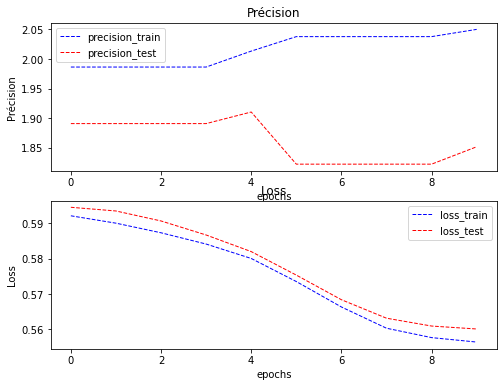

Finished Training
---Accuracy--- = 1.851670422259234
loss_train = [0.5921185457308756, 0.5900331126103611, 0.5873137058121076, 0.5841281014935189, 0.580051277850964, 0.5735239195623946, 0.5663322992445832, 0.5603220928703991, 0.5576678886421984, 0.556410217707963]
loss_test = [0.5945260387169131, 0.5934804201803491, 0.5906570700294791, 0.5866892784644122, 0.5819928416007994, 0.5753458983939974, 0.5683834021362651, 0.5631568168138587, 0.5609401035019195, 0.5601070180186402]
accuracy_train = [1.9864792044285504, 1.9864792044285504, 1.9864792044285504, 1.9864792044285504, 2.0134228187919465, 2.037917013667761, 2.037917013667761, 2.037917013667761, 2.037917013667761, 2.050164111105668]
accuracy_test = [1.8908592142647203, 1.8908592142647203, 1.8908592142647203, 1.8908592142647203, 1.9104536102674634, 1.822278828255119, 1.822278828255119, 1.822278828255119, 1.822278828255119, 1.851670422259234]


In [ ]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
top5train(net, optimizer, trainloader, testloader, criterion_arcface, n_epoch = 10,PATH = 'resnet50_with_ARCFACE_individuals_10epoch_cropped__1fc',
      train_acc_period = 10,
      test_acc_period = 1000, cuda = use_cuda)

# Generate 1st Kaggle Prediction

In [ ]:
submission = pd.read_csv('sample_submission.csv')
submission.head()

,image,predictions
0,000110707af0ba.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
1,0006287ec424cb.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
2,000809ecb2ccad.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
3,00098d1376dab2.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
4,000b8d89c738bd.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...


In [ ]:
submission.iloc[0,0]

'000110707af0ba.jpg'

In [ ]:
def top5_predictions_to_string(net_output):
    _, preds = torch.topk(net_output.data, k=5)
    preds_str = ""
    for i,pred in enumerate(preds):
        pred = int(pred)
        if i<4:
            preds_str += int_id_to_string_id(pred) + " "
        else:
            preds_str += int_id_to_string_id(pred)
    return preds_str

In [ ]:
def model_submission(net, PATH = 'last_submission.csv', cuda=True):
    """
    Sauvegarder les prediction d'un modele en csv pour kaggle
    """
    net.eval()
    df_submission = pd.read_csv('sample_submission.csv')
    count = 0
    with torch.no_grad():
        for data in tqdm(valloader, desc='Processing validation_dataloader', leave=False):
            images = data['image']
            if cuda:
                images = images.type(torch.cuda.FloatTensor)
            output = net(images)[0]
            df_submission.iloc[count,1] = top5_predictions_to_string(output)
            count += 1
    net.train()
    df_submission.to_csv(PATH, index=False)
    print(f'Saved submission under {PATH}')

In [ ]:
model_submission(net, PATH = 'effnetb4_1AUG_pretrain_submission.csv', cuda=True)

Processing validation_dataloader:   0%|          | 0/27956 [00:00<?, ?it/s]

Saved submission under effnetb4_1AUG_pretrain_submission.csv


In [ ]:
submission_effnet = pd.read_csv('effnetb7_1AUG_submission.csv')
submission_effnet.head()

,Unnamed: 0,image,predictions
0,0,000110707af0ba.jpg,fbe2b15b5481 a8c9dfb8ac6f a5a4dc77bb63 584045b...
1,1,0006287ec424cb.jpg,c3b7d902e73c f0efb5bcc5d3 00f74ae6e8ee 5a47f04...
2,2,000809ecb2ccad.jpg,e94c173e5720 7593d2aee842 dba4e482f0ad a0d9288...
3,3,00098d1376dab2.jpg,70601e9b0830 0c782ed6e0d6 c1990a5cb6c2 55be3bf...
4,4,000b8d89c738bd.jpg,da9cc7804e3a 42800048d560 d646f1955d19 33dcbb2...


In [ ]:
submission_effnet.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
submission_effnet.to_csv('effnetb7_1AUG_submission_noindex.csv', index=False)

In [ ]:
PATH = "models/resnet18_arcface_one_epoch.pth"
net = torch.load(PATH)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
train(net, optimizer, trainloader, testloader, criterion, n_epoch = 1,
      train_acc_period = 10,
      test_acc_period = 1000, cuda = use_cuda)

using cuda


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/638 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f969a07ea60>
Traceback (most recent call last):
  File "/anaconda/envs/py38_default/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/anaconda/envs/py38_default/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1322, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/anaconda/envs/py38_default/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/anaconda/envs/py38_default/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/anaconda/envs/py38_default/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/anaconda/envs/py38_default/lib/python3.8/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
Accuracy = 83.1978054276477

In [ ]:
PATH = "models/resnet18_arcface_one_epoch.pth"
torch.save(net, PATH)

# ARCFACE Individuals

In [ ]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Sequential(
            #nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(),
            #nn.Dropout(),
            Arcface(512, N_individus),
)

# EffNet B7 sans ArcFace sans dropout (essayer sans dropout et sans logsoftmax)

In [ ]:
net = models.efficientnet_b7(pretrained=True)
net.classifier = nn.Sequential(
            nn.Linear(2560, N_individus),
#             nn.LogSoftmax(dim=1)
)

using cuda


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 0: precision_train = 7.159653162200558, cout_train = 0.4565774089812485, precision_test = 5.97629078083668, cout_test =0.49356477062277293
Saved model under effnet_b7_arcface_individuals_crop_1fc.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 1: precision_train = 14.067016117180229, cout_train = 0.38457778167883455, precision_test = 9.669834427353777, cout_test =0.48570168879095904
Saved model under effnet_b7_arcface_individuals_crop_1fc.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 2: precision_train = 27.39185812962328, cout_train = 0.3142510284571834, precision_test = 15.35220926814931, cout_test =0.4873075823925426
Saved model under effnet_b7_arcface_individuals_crop_1fc.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 3: precision_train = 57.14250722578749, cout_train = 0.2152303532477672, precision_test = 20.485941020868033, cout_test =0.5270952725020377
Saved model under effnet_b7_arcface_individuals_crop_1fc.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 4: precision_train = 82.13393425758095, cout_train = 0.11382821074968946, precision_test = 23.650435975311062, cout_test =0.5673807264600641
Saved model under effnet_b7_arcface_individuals_crop_1fc.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 5: precision_train = 91.55195218733161, cout_train = 0.06177175525598323, precision_test = 26.403448613696483, cout_test =0.6205179811843733
Saved model under effnet_b7_arcface_individuals_crop_1fc.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 6: precision_train = 95.42448439719786, cout_train = 0.042534598806664096, precision_test = 28.176741451944743, cout_test =0.6387076512879859
Saved model under effnet_b7_arcface_individuals_crop_1fc.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 7: precision_train = 97.86655562631657, cout_train = 0.026398185327935086, precision_test = 28.51964338199275, cout_test =0.6505160142990685
Saved model under effnet_b7_arcface_individuals_crop_1fc.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 8: precision_train = 98.91245774751384, cout_train = 0.017716515998739787, precision_test = 29.391594004114822, cout_test =0.6449117323228027
Saved model under effnet_b7_arcface_individuals_crop_1fc.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 9: precision_train = 99.15739969627198, cout_train = 0.01498303246445451, precision_test = 28.039580679925542, cout_test =0.6451023012017181
Saved model under effnet_b7_arcface_individuals_crop_1fc.pth


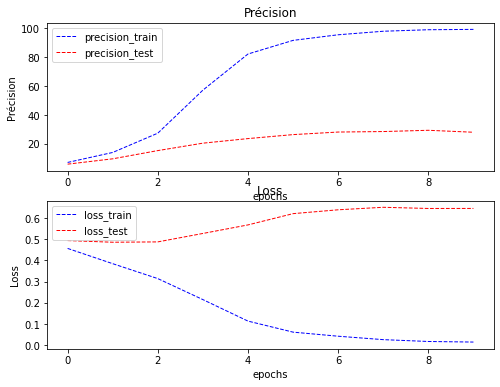

Finished Training
---Accuracy--- = 28.039580679925542
loss_train = [0.4565774089812485, 0.38457778167883455, 0.3142510284571834, 0.2152303532477672, 0.11382821074968946, 0.06177175525598323, 0.042534598806664096, 0.026398185327935086, 0.017716515998739787, 0.01498303246445451]
loss_test = [0.49356477062277293, 0.48570168879095904, 0.4873075823925426, 0.5270952725020377, 0.5673807264600641, 0.6205179811843733, 0.6387076512879859, 0.6505160142990685, 0.6449117323228027, 0.6451023012017181]
accuracy_train = [7.159653162200558, 14.067016117180229, 27.39185812962328, 57.14250722578749, 82.13393425758095, 91.55195218733161, 95.42448439719786, 97.86655562631657, 98.91245774751384, 99.15739969627198]
accuracy_test = [5.97629078083668, 9.669834427353777, 15.35220926814931, 20.485941020868033, 23.650435975311062, 26.403448613696483, 28.176741451944743, 28.51964338199275, 29.391594004114822, 28.039580679925542]


In [ ]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
top5train(net, optimizer, trainloader, testloader, criterion, n_epoch = 10, PATH="effnet_b7_arcface_individuals_crop_1fc.pth",
      train_acc_period = 10,
      test_acc_period = 1000, cuda = use_cuda)

In [ ]:
# PATH = "effnet_b7_arcface_individuals_3epochs.pth"
# torch.save(net, PATH)

# EffNet B7 sans ArcFace 10 augmentation

In [ ]:
PATH = 'effnet_b7_arcface_individuals_crop_1fc.pth'
net = torch.load(PATH)

In [ ]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 8e-3 #batchsize=128 au lieu de 16
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
top5train(net, optimizer, trainloader, testloader, criterion, n_epoch = 2, PATH="effnet_b7_arcface_individuals_crop_1fc_10_AUG_3epochs.pth",
      train_acc_period = 10,
      test_acc_period = 1000, cuda = use_cuda)

using cuda


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/25517 [00:00<?, ?it/s]

# EffNet B7 avec ArcFace (à executer)

In [ ]:
net = models.efficientnet_b7(pretrained=True)
net.classifier = MyArcFaceClassifier(2560, N_individus)

In [ ]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
top5train(net, optimizer, trainloader, testloader, criterion_arcface, n_epoch = 3, PATH="effnet_b7_AVEC_arcface_individuals.pth",
      train_acc_period = 10,
      test_acc_period = 1000, cuda = use_cuda)

# EffNet B4 dropout 0.6 1fc

In [ ]:
net = models.efficientnet_b4(pretrained=True)

myclassifier = nn.Sequential(
            nn.Dropout(0.6),
            nn.Linear(1792, N_individus)
            )
myclassifier.apply(init_weights)

net.classifier = myclassifier

using cuda


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 0: precision_train = 11.909077548620976, cout_train = 0.45381299354862686, precision_test = 9.307338101303028, cout_test =0.48571019374951685
Saved model under effnet_b4_arcface_individuals_dropout06_1fc.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 1: precision_train = 23.382158428452456, cout_train = 0.3990431502209589, precision_test = 17.61536200646615, cout_test =0.46571175092299305
Saved model under effnet_b4_arcface_individuals_dropout06_1fc.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 2: precision_train = 36.16567873414001, cout_train = 0.34085421607045036, precision_test = 24.80650533947291, cout_test =0.4467864842422798
Saved model under effnet_b4_arcface_individuals_dropout06_1fc.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 3: precision_train = 47.47219908881595, cout_train = 0.28868530882582777, precision_test = 30.087195062212206, cout_test =0.443409919084736
Saved model under effnet_b4_arcface_individuals_dropout06_1fc.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 4: precision_train = 59.01141429481213, cout_train = 0.23407412884032505, precision_test = 33.966885470755365, cout_test =0.43886775670070727
Saved model under effnet_b4_arcface_individuals_dropout06_1fc.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 5: precision_train = 67.92730122960859, cout_train = 0.1901772348885907, precision_test = 36.37699617909278, cout_test =0.4436561827259245
Saved model under effnet_b4_arcface_individuals_dropout06_1fc.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 6: precision_train = 77.38450987116053, cout_train = 0.14500427035566396, precision_test = 38.1306946213383, cout_test =0.4481062782818673
Saved model under effnet_b4_arcface_individuals_dropout06_1fc.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 7: precision_train = 85.40390927350218, cout_train = 0.10579504384113796, precision_test = 39.159400411482316, cout_test =0.46060778317564066
Saved model under effnet_b4_arcface_individuals_dropout06_1fc.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 8: precision_train = 93.52863371380982, cout_train = 0.07515341681633333, precision_test = 39.61986871754678, cout_test =0.4687779052280663
Saved model under effnet_b4_arcface_individuals_dropout06_1fc.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 9: precision_train = 98.16783422328908, cout_train = 0.04580813577394643, precision_test = 40.34486136964828, cout_test =0.4754503405128016
Saved model under effnet_b4_arcface_individuals_dropout06_1fc.pth


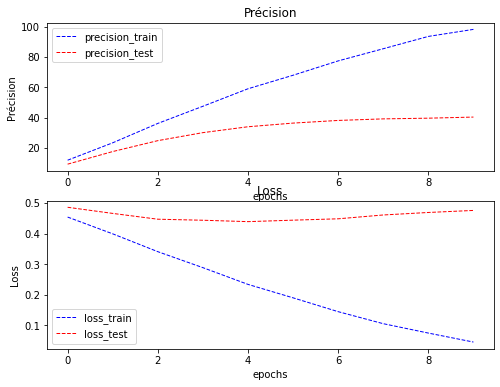

Finished Training
---Accuracy--- = 40.34486136964828
loss_train = [0.45381299354862686, 0.3990431502209589, 0.34085421607045036, 0.28868530882582777, 0.23407412884032505, 0.1901772348885907, 0.14500427035566396, 0.10579504384113796, 0.07515341681633333, 0.04580813577394643]
loss_test = [0.48571019374951685, 0.46571175092299305, 0.4467864842422798, 0.443409919084736, 0.43886775670070727, 0.4436561827259245, 0.4481062782818673, 0.46060778317564066, 0.4687779052280663, 0.4754503405128016]
accuracy_train = [11.909077548620976, 23.382158428452456, 36.16567873414001, 47.47219908881595, 59.01141429481213, 67.92730122960859, 77.38450987116053, 85.40390927350218, 93.52863371380982, 98.16783422328908]
accuracy_test = [9.307338101303028, 17.61536200646615, 24.80650533947291, 30.087195062212206, 33.966885470755365, 36.37699617909278, 38.1306946213383, 39.159400411482316, 39.61986871754678, 40.34486136964828]


In [ ]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
top5train(net, optimizer, trainloader, testloader, criterion, n_epoch = 10, PATH="effnet_b4_arcface_individuals_dropout06_1fc.pth",
      train_acc_period = 10,
      test_acc_period = 1000, cuda = use_cuda)

with dropout =  0.8 :

Epoch 0: precision_train = 7.382550335570469, cout_train = 0.48694047819001246, precision_test = 6.593514254923092, cout_test =0.5092117373665598
Saved model under effnet_b4_arcface_individuals_dropout08_1fc.pth
Epoch 1: precision_train = 9.932396022142752, cout_train = 0.46111817369968894, precision_test = 7.965121975115117, cout_test =0.508394823609714
Saved model under effnet_b4_arcface_individuals_dropout08_1fc.pth

# EffNet B4 dropout 0.6 1fc 10 aug

In [ ]:
net = models.efficientnet_b4(pretrained=True)

myclassifier = nn.Sequential(
            nn.Dropout(0.6),
            nn.Linear(1792, N_individus)
            )
myclassifier.apply(init_weights)

net.classifier = myclassifier

using cuda


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/25517 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/25517 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 0: precision_train = 82.23803458580316, cout_train = 0.11962844081139427, precision_test = 37.689820711276575, cout_test =0.48025535768681016
Saved model under effnet_b4_arcface_individuals_dropout06_1fc_10aug.pth


Processing epoch:   0%|          | 0/25517 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/25517 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 1: precision_train = 99.42904031744476, cout_train = 0.011334591860383393, precision_test = 41.05025962574704, cout_test =0.4669622823448551
Saved model under effnet_b4_arcface_individuals_dropout06_1fc_10aug.pth


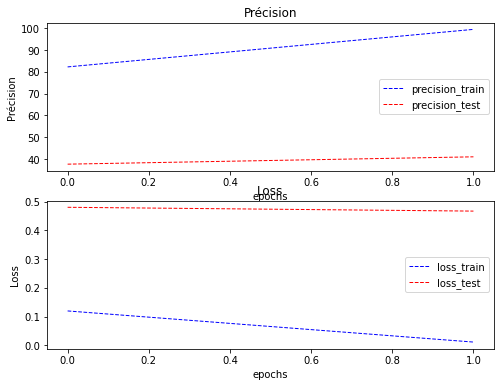

Finished Training
---Accuracy--- = 41.05025962574704
loss_train = [0.11962844081139427, 0.011334591860383393]
loss_test = [0.48025535768681016, 0.4669622823448551]
accuracy_train = [82.23803458580316, 99.42904031744476]
accuracy_test = [37.689820711276575, 41.05025962574704]


In [ ]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
top5train(net, optimizer, trainloader, testloader, criterion, n_epoch = 2, PATH="effnet_b4_arcface_individuals_dropout06_1fc_10aug.pth",
      train_acc_period = 10,
      test_acc_period = 1000, cuda = use_cuda)

# EffNet B4 dropout 0.6 1fc 1 aug pretrained on species

In [ ]:
net = models.efficientnet_b4(pretrained=True)

myclassifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(1792, N_species)
            )
myclassifier.apply(init_weights)

net.classifier = myclassifier

using cuda


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 0: precision_train = 99.6448341743007, cout_train = 0.007195109477592618, precision_test = 99.32399333790536, cout_test =0.010971241405835401
Saved model under effnet_b4_species_dropout06_1fc.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 1: precision_train = 99.80404644099349, cout_train = 0.005529249268472685, precision_test = 99.37297932791222, cout_test =0.010318017706393751
Saved model under effnet_b4_species_dropout06_1fc.pth


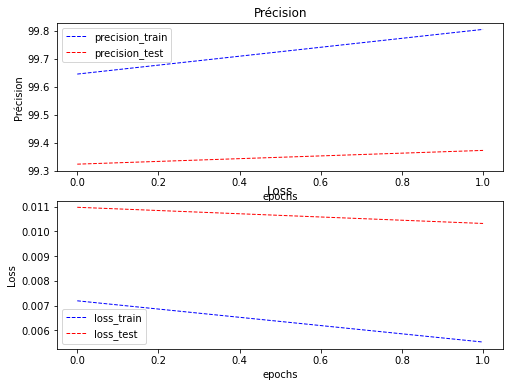

Finished Training
---Accuracy--- = 99.37297932791222
loss_train = [0.007195109477592618, 0.005529249268472685]
loss_test = [0.010971241405835401, 0.010318017706393751]
accuracy_train = [99.6448341743007, 99.80404644099349]
accuracy_test = [99.32399333790536, 99.37297932791222]


In [ ]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
top5train(net, optimizer, trainloader, testloader, criterion, n_epoch = 2, PATH="effnet_b4_species_dropout06_1fc.pth",
      train_acc_period = 10,
      test_acc_period = 1000, cuda = use_cuda)

In [ ]:
net = models.efficientnet_b4(pretrained=True)

myclassifier = nn.Sequential(
            nn.Dropout(0.6),
            nn.Linear(1792, N_species)
            )
myclassifier.apply(init_weights)

net.classifier = myclassifier

In [ ]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
top5train(net, optimizer, trainloader, testloader, criterion, n_epoch = 5, PATH="effnet_b4_species_dropout06_1fc.pth",
      train_acc_period = 10,
      test_acc_period = 1000, cuda = use_cuda)

using cuda


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 0: precision_train = 99.6448341743007, cout_train = 0.007606823067299043, precision_test = 99.19662976388753, cout_test =0.011176072566342793
Saved model under effnet_b4_species_dropout06_1fc.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
PATH="effnet_b4_species_dropout06_1fc.pth"
net = torch.load(PATH)

myclassifier = nn.Sequential(
            nn.Dropout(0.6),
            nn.Linear(1792, N_individus)
            )
myclassifier.apply(init_weights)

net.classifier = myclassifier

using cuda


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 0: precision_train = 16.861803752510657, cout_train = 0.4325150111990826, precision_test = 13.373175271872245, cout_test =0.46839951104745
Saved model under effnet_b4_individuals_dropout06_1fc_pretrain.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 1: precision_train = 31.418703767207173, cout_train = 0.36886365009079497, precision_test = 22.72949936318213, cout_test =0.4431434037858947
Saved model under effnet_b4_individuals_dropout06_1fc_pretrain.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 2: precision_train = 43.43065693430657, cout_train = 0.3094840879209749, precision_test = 29.019300480062704, cout_test =0.4315867123856558
Saved model under effnet_b4_individuals_dropout06_1fc_pretrain.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 3: precision_train = 54.555920246901486, cout_train = 0.2564403050785488, precision_test = 33.5749975507005, cout_test =0.42824613596020267
Saved model under effnet_b4_individuals_dropout06_1fc_pretrain.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 4: precision_train = 64.08171263410571, cout_train = 0.20676137839323488, precision_test = 36.886450475164104, cout_test =0.429367315270495
Saved model under effnet_b4_individuals_dropout06_1fc_pretrain.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 5: precision_train = 73.0465879586538, cout_train = 0.16442114692543602, precision_test = 38.356030175369845, cout_test =0.4343589383474092
Saved model under effnet_b4_individuals_dropout06_1fc_pretrain.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 6: precision_train = 81.17866065742419, cout_train = 0.12055984084182664, precision_test = 39.66885470755364, cout_test =0.4472735502045524
Saved model under effnet_b4_individuals_dropout06_1fc_pretrain.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 7: precision_train = 89.8104149316612, cout_train = 0.08618788327697835, precision_test = 41.11884001175664, cout_test =0.45275233802616016
Saved model under effnet_b4_individuals_dropout06_1fc_pretrain.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 8: precision_train = 96.20584921373634, cout_train = 0.054078930474360416, precision_test = 41.60869991182522, cout_test =0.46117257266036676
Saved model under effnet_b4_individuals_dropout06_1fc_pretrain.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 9: precision_train = 99.24312937833733, cout_train = 0.033905109383042836, precision_test = 42.0299794258842, cout_test =0.46605934192305787
Saved model under effnet_b4_individuals_dropout06_1fc_pretrain.pth


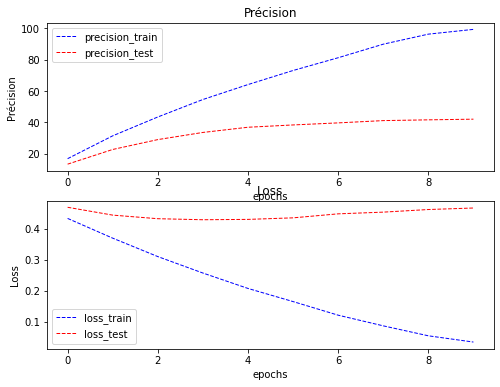

Finished Training
---Accuracy--- = 42.0299794258842
loss_train = [0.4325150111990826, 0.36886365009079497, 0.3094840879209749, 0.2564403050785488, 0.20676137839323488, 0.16442114692543602, 0.12055984084182664, 0.08618788327697835, 0.054078930474360416, 0.033905109383042836]
loss_test = [0.46839951104745, 0.4431434037858947, 0.4315867123856558, 0.42824613596020267, 0.429367315270495, 0.4343589383474092, 0.4472735502045524, 0.45275233802616016, 0.46117257266036676, 0.46605934192305787]
accuracy_train = [16.861803752510657, 31.418703767207173, 43.43065693430657, 54.555920246901486, 64.08171263410571, 73.0465879586538, 81.17866065742419, 89.8104149316612, 96.20584921373634, 99.24312937833733]
accuracy_test = [13.373175271872245, 22.72949936318213, 29.019300480062704, 33.5749975507005, 36.886450475164104, 38.356030175369845, 39.66885470755364, 41.11884001175664, 41.60869991182522, 42.0299794258842]


In [ ]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
top5train(net, optimizer, trainloader, testloader, criterion, n_epoch = 10, PATH="effnet_b4_individuals_dropout06_1fc_pretrain.pth",
      train_acc_period = 10,
      test_acc_period = 1000, cuda = use_cuda)

# EffNet B4 sans ArcFace 1fc

In [ ]:
net = models.efficientnet_b4(pretrained=True)
net.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(1792, N_individus)
)
# from torchsummary import summary
# use_cuda = True
# if use_cuda and torch.cuda.is_available():
#     print("using cuda")
#     net.cuda()
# summary(net,(3, 128, 128))
# net

In [ ]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
top5train(net, optimizer, trainloader, testloader, criterion, n_epoch = 10, PATH="effnet_b4_arcface_individuals_crop_1fc.pth",
      train_acc_period = 10,
      test_acc_period = 1000, cuda = use_cuda)

using cuda


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 0: precision_train = 17.689707539313183, cout_train = 0.4261098903017264, precision_test = 13.382972469873616, cout_test =0.4611846953353067
Saved model under effnet_b4_arcface_individuals_crop_1fc.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 1: precision_train = 37.50796061333464, cout_train = 0.33140341884472135, precision_test = 24.355834231409816, cout_test =0.43199536400256155
Saved model under effnet_b4_arcface_individuals_crop_1fc.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 2: precision_train = 57.39724685249596, cout_train = 0.2357811088313934, precision_test = 32.32095620652493, cout_test =0.4155523893332591
Saved model under effnet_b4_arcface_individuals_crop_1fc.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 3: precision_train = 76.31166413559987, cout_train = 0.14669999708294465, precision_test = 36.161457823062605, cout_test =0.4201777099313378
Saved model under effnet_b4_arcface_individuals_crop_1fc.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 4: precision_train = 92.6345956008426, cout_train = 0.07326640876284078, precision_test = 38.875281669442536, cout_test =0.4343895337088073
Saved model under effnet_b4_arcface_individuals_crop_1fc.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 5: precision_train = 98.9712438152158, cout_train = 0.028391381568676745, precision_test = 41.08944841775252, cout_test =0.4533224818731506
Saved model under effnet_b4_arcface_individuals_crop_1fc.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 6: precision_train = 99.85303483074512, cout_train = 0.00893761974672988, precision_test = 40.442833349661996, cout_test =0.49431399015765054
Saved model under effnet_b4_arcface_individuals_crop_1fc.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 7: precision_train = 99.92651741537256, cout_train = 0.004463420874300974, precision_test = 40.63877730968943, cout_test =0.5102432192954445
Saved model under effnet_b4_arcface_individuals_crop_1fc.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

KeyboardInterrupt: 

# EffNet B4 sans ArcFace 2fc Freeze

In [ ]:
net = models.efficientnet_b4(pretrained=True)

for param in net.parameters(): #freeze the layers
    param.requires_grad = False

net.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(1792, 512),
            nn.ReLU(),
            nn.Dropout(0.4), #pas fou le dropout ici en fait
            nn.Linear(512, N_individus)
            )

In [ ]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
top5train(net, optimizer, trainloader, testloader, criterion, n_epoch = 10, PATH="effnet_b4_arcface_individuals_crop_2fc_freeze.pth",
      train_acc_period = 10,
      test_acc_period = 1000, cuda = use_cuda)

using cuda


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 0: precision_train = 7.198843874001861, cout_train = 0.49600057492606325, precision_test = 5.819535612814735, cout_test =0.5233846341896748
Saved model under effnet_b4_arcface_individuals_crop_1fc.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 1: precision_train = 8.330475677264488, cout_train = 0.4811883904410327, precision_test = 6.172234740864113, cout_test =0.5297352926404326
Saved model under effnet_b4_arcface_individuals_crop_1fc.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 2: precision_train = 9.082447459951991, cout_train = 0.4679419340171883, precision_test = 6.848241402958754, cout_test =0.5379152961350496
Saved model under effnet_b4_arcface_individuals_crop_1fc.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

KeyboardInterrupt: 

# EffNet B4 sans ArcFace 2fc Freeze xavier

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
#         nn.init.xavier_uniform_(m.weight)
        nn.init.xavier_normal_(m.weight)


In [ ]:
net = models.efficientnet_b4(pretrained=True)

for param in net.parameters(): #freeze the layers
    param.requires_grad = False

myclassifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(1792, 512),
            nn.ReLU(),
#             nn.Dropout(0.4),
            nn.Linear(512, N_individus)
            )
myclassifier.apply(init_weights)

net.classifier = myclassifier

In [ ]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()),lr=learning_rate)
top5train(net, optimizer, trainloader, testloader, criterion, n_epoch = 10, PATH="effnet_b4_arcface_individuals_crop_2fc_freeze_xavier.pth",
      train_acc_period = 10,
      test_acc_period = 1000, cuda = use_cuda)

using cuda


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 0: precision_train = 7.583402733552148, cout_train = 0.4865683533318079, precision_test = 6.358381502890174, cout_test =0.5186910830154188
Saved model under effnet_b4_arcface_individuals_crop_2fc_freeze_xavier.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 1: precision_train = 9.275951599470925, cout_train = 0.4553616631126226, precision_test = 7.220534927010875, cout_test =0.5226622238394631
Saved model under effnet_b4_arcface_individuals_crop_2fc_freeze_xavier.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 2: precision_train = 10.72600793611914, cout_train = 0.43643175064714446, precision_test = 7.847555599098658, cout_test =0.5354361937750772
Saved model under effnet_b4_arcface_individuals_crop_2fc_freeze_xavier.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 3: precision_train = 12.026649684024886, cout_train = 0.42105891234683296, precision_test = 8.112079945135692, cout_test =0.5477755267110641
Saved model under effnet_b4_arcface_individuals_crop_2fc_freeze_xavier.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

KeyboardInterrupt: 

# EffNet B4 sans ArcFace 2fc (512 embedding too small)

In [ ]:
net = models.efficientnet_b4(pretrained=True)

# for param in net.parameters(): #freeze the layers
#     param.requires_grad = False

myclassifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1792, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, N_individus)
            )
myclassifier.apply(init_weights)

net.classifier = myclassifier

In [ ]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
top5train(net, optimizer, trainloader, testloader, criterion, n_epoch = 10, PATH="effnet_b4_arcface_individuals_crop_2fc_xavier.pth",
      train_acc_period = 10,
      test_acc_period = 1000, cuda = use_cuda)

using cuda


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 0: precision_train = 6.792240239063342, cout_train = 0.47136170604931743, precision_test = 6.221220730870971, cout_test =0.4981397601408205
Saved model under effnet_b4_arcface_individuals_crop_2fc_xavier.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 1: precision_train = 8.038994758242296, cout_train = 0.4444996312370855, precision_test = 6.985402174977956, cout_test =0.4971012128746053
Saved model under effnet_b4_arcface_individuals_crop_2fc_xavier.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

KeyboardInterrupt: 

# EffNet B4 sans ArcFace 1fc Freeze

In [ ]:
net = models.efficientnet_b4(pretrained=True)

for param in net.parameters(): #freeze the layers
    param.requires_grad = False

myclassifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(1792, N_individus)
            )
myclassifier.apply(init_weights)

net.classifier = myclassifier

In [ ]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()),lr=learning_rate)
top5train(net, optimizer, trainloader, testloader, criterion, n_epoch = 10, PATH="effnet_b4_arcface_individuals_crop_1fc_freeze_xavier.pth",
      train_acc_period = 10,
      test_acc_period = 1000, cuda = use_cuda)

using cuda


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 0: precision_train = 20.45020330181747, cout_train = 0.47991757364151133, precision_test = 10.316449495444303, cout_test =0.5676764076365959
Saved model under effnet_b4_arcface_individuals_crop_1fc_freeze_xavier.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 1: precision_train = 35.48474011659237, cout_train = 0.3966405653961728, precision_test = 13.157636915842069, cout_test =0.5665054164788182
Saved model under effnet_b4_arcface_individuals_crop_1fc_freeze_xavier.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 2: precision_train = 51.13653064223779, cout_train = 0.319292787842612, precision_test = 14.705594200058783, cout_test =0.5620078631756389
Saved model under effnet_b4_arcface_individuals_crop_1fc_freeze_xavier.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
from pytorch_metric_learning import losses

# losses.ArcFaceLoss(num_classes, embedding_size, margin=28.6, scale=64, **kwargs)

criterion_arcface = losses.ArcFaceLoss(N_individus, 2560, margin=28.6, scale=64)

# Convnext

In [ ]:
net = models.convnext_small()
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
summary(net,(3, 64, 64))

using cuda
Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 768, 2, 2]           --
|    └─ConvNormActivation: 2-1                [-1, 96, 16, 16]          --
|    |    └─Conv2d: 3-1                       [-1, 96, 16, 16]          4,704
|    |    └─LayerNorm2d: 3-2                  [-1, 96, 16, 16]          192
|    └─Sequential: 2-2                        [-1, 96, 16, 16]          --
|    |    └─CNBlock: 3-3                      [-1, 96, 16, 16]          79,296
|    |    └─CNBlock: 3-4                      [-1, 96, 16, 16]          79,296
|    |    └─CNBlock: 3-5                      [-1, 96, 16, 16]          79,296
|    └─Sequential: 2-3                        [-1, 192, 8, 8]           --
|    |    └─LayerNorm2d: 3-6                  [-1, 96, 16, 16]          192
|    |    └─Conv2d: 3-7                       [-1, 192, 8, 8]           73,920
|    └─Sequential: 2-4                        [-1, 192, 8, 8]  

Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 768, 2, 2]           --
|    └─ConvNormActivation: 2-1                [-1, 96, 16, 16]          --
|    |    └─Conv2d: 3-1                       [-1, 96, 16, 16]          4,704
|    |    └─LayerNorm2d: 3-2                  [-1, 96, 16, 16]          192
|    └─Sequential: 2-2                        [-1, 96, 16, 16]          --
|    |    └─CNBlock: 3-3                      [-1, 96, 16, 16]          79,296
|    |    └─CNBlock: 3-4                      [-1, 96, 16, 16]          79,296
|    |    └─CNBlock: 3-5                      [-1, 96, 16, 16]          79,296
|    └─Sequential: 2-3                        [-1, 192, 8, 8]           --
|    |    └─LayerNorm2d: 3-6                  [-1, 96, 16, 16]          192
|    |    └─Conv2d: 3-7                       [-1, 192, 8, 8]           73,920
|    └─Sequential: 2-4                        [-1, 192, 8, 8]           --

In [ ]:
net = models.convnext_small(pretrained=True)
net.classifier = nn.Sequential(
            nn.LayerNorm((768,1,1), eps=1e-06, elementwise_affine=True),
            nn.Flatten(start_dim=1, end_dim=-1),
            nn.Linear(in_features=768, out_features=N_individus, bias=True)
            )

In [ ]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
top5train(net, optimizer, trainloader, testloader, criterion, n_epoch = 5, PATH="convnext_individuals_5epoch_1fc.pth",
      train_acc_period = 10,
      test_acc_period = 1000, cuda = use_cuda)

using cuda


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 0: precision_train = 1.8664576495370597, cout_train = 0.5454602296410902, precision_test = 1.7536984422455177, cout_test =0.5772216101170193
Saved model under convnext_individuals_5epoch_1fc.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/2552 [00:00<?, ?it/s]

Processing accuracy:   0%|          | 0/638 [00:00<?, ?it/s]

Epoch 1: precision_train = 1.9864792044285504, cout_train = 0.539359017997091, precision_test = 1.851670422259234, cout_test =0.5915116469610376
Saved model under convnext_individuals_5epoch_1fc.pth


Processing epoch:   0%|          | 0/2552 [00:00<?, ?it/s]

KeyboardInterrupt: 